# Pivot Work



In [10]:
import numpy as np
import pymongo
import pandas as pd
from scipy.stats import ks_2samp, describe, skew
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import copy
import seaborn as sns
from scipy import stats
from ast import literal_eval
import random


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.datasets.samples_generator import make_blobs
from pandas.plotting import parallel_coordinates
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from mpl_toolkits import mplot3d


import pdb

pd.options.display.max_columns = 500



## Functions

In [20]:
"""To simplify our manual labeling we will simple sweep through a labeled word in the fake audio process (the 
fake acoustic core runs) searching for bigram we know should be in that word for that speakers. So that means we 
to augment the both dataset with word labels.

--> How do we handle one window overlapping 2 words...? (Ans: If at least half of window in word, we will treat it as 
                        being a part of that word.)
"""
#augment deepfake processed data with word labels
def add_words(df):
    fake_files = df.groupby(['filepath'])
    df_aug = []
    for key, grp in fake_files:
        #read associated WRD file
        tmp = convert_unix(key)
        df_wrds = pd.read_csv(tmp[:-3] + 'WRD', delimiter=' ', header=None, names=['start', 'end', 'word'])

        word_assignments = []
        #assign words to rows of the grp
        for _, row in grp.iterrows():
            #get middle div
            divide = (row.window_end - row.window_start) / 2 + row.window_start
            word = df_wrds[(df_wrds.start < divide) & (df_wrds.end > divide)]['word'].values
            if len(word) > 0:
                word = word[0]
            else:
                word = None
            word_assignments.append(word)
        grp['word'] = word_assignments 
        df_aug.append(grp)
    return pd.concat(df_aug, ignore_index=True)

def convert_unix(path):
    root_research = '/home/logan/SynologyDrive/'
    tmp = root_research + path.replace('\\', '/')[path.find('Research'):]
    return tmp.replace('//', '/')

"""===============Augment data=====================
Function to augment/manipulate the data from the acoustic core 
in order to allow for the area distributions to be analyzed properly

"""

def augment(input_vals):
    #set up
    key, item = input_vals
    index_area = grouped_df.get_group(key)
    area_distros = pd.DataFrame(columns=['speaker_id', 'prev_index', 'sex', 'label', 'window', \
                                         'dimension', 'distro', 'word'])
    
    #get the area curves separately
    area_curves = index_area['cross_sect_est'].to_list()
    area_per_dim = list(zip(*area_curves))
    
    #add to new working df
    tmp = index_area['cross_sect_est'].tolist()
    tmp = list(zip(*tmp))
    new_row = {}
    new_row['speaker_id'] = index_area['speaker_id'].values[0]
    new_row['sex'] = index_area['sex'].values[0]
    new_row['label'] = index_area['label'].values[0]
    new_row['window'] = int(index_area['window_index'].values[0])
    new_row['prev_index'] = index_area.index[0]
    new_row['word'] = index_area['word'].values[0]
    new_row['filepath'] = index_area['filepath'].values[0]
    for index in range(0, len(tmp)):
        new_row['dimension'] = index
        new_row['distro'] = list(tmp[index])
        area_distros = area_distros.append(new_row, ignore_index=True)
    return area_distros

In [12]:
def get_pronunciation(df_tmp, curr_speaker, curr_word):
    #get word in ipa
    #check to see if we have the exact same speaker saying that word (Ideal)
    bigrams_needed = df_tmp[(df_tmp.speaker_id == curr_speaker) & (df_tmp.word == curr_word)]['label'].unique()
    #check if we got luckily with the speaker saying the word before
    if len(bigrams_needed) == 0:
        #we do not have this speaker, find other speaker's who say this word and 
        #use their pronunciation     
        pronuns = df_tmp[(df_tmp.word == curr_word)][['speaker_id', 'label']].drop_duplicates()

        #check that this word appears in our dataset at all
        if len(pronuns) > 0:
            df_pronun = []
            for speaker, grp in pronuns.groupby('speaker_id'):
                pronunciation = []
                for _, row in grp.iterrows():
                    pronunciation.append(row['label'])
                    pronunciation.sort()
                    #convert to string so I can search by later
                    str_pron = ''
                    for x in pronunciation:
                        str_pron += x + ":"
                    str_pron

                df_pronun.append(pd.DataFrame({'speaker_id':[speaker], 'label':[str_pron]}))
            df_pronun = pd.concat(df_pronun, ignore_index=True)
            
            common_pron = df_pronun.groupby('label').agg('count').idxmax()[0]     #found the most common pronunciation
            #no rebreak out the bigrams
            bigrams_needed = []
            while True:
                index = common_pron.find(':')
                if index != -1:
                    bigrams_needed.append(common_pron[:index])
                    common_pron = common_pron[index+1:]
                else:
                    break
        else:
            #welp..... we're just going to ignore this word since we can't get the pronunciation right anyways
            bigrams_needed = []
    return bigrams_needed

def fake_data_add_labels(df_fake, df_true):
    new_groups = []
    for keys, grp in tqdm(df_dim_fakes.groupby(['speaker_id', 'word']), position=0,
                          leave=True):
        bigrams = get_pronunciation(df_dim_train, keys[0], keys[1])

        #for every bigram in this word, duplicate every row in this group with one 
        #label labeled as the appropriate label
        for _, row in grp.iterrows():
            row['label'] = bigrams
        new_groups.append(grp)

    ##compile into a single dataframe
    df_output = pd.concat(new_groups, ignore_index=True)
    df_output = df_output.explode('label')
    return df_output

In [17]:
path = df.filepath.values[0]
root_research = '/home/logan/drive/'
tmp = root_research + path.replace('\\', '/')[path.find('Research'):]
tmp.replace('//', '/')

'/home/logan/drive/Research/guesswho_new/guesswho18/data/extended_data/guesswho_fakes/TIMIT_TRAIN_DR1_FDAW0_SA1_fake.wav'

In [21]:
"""Break in to add in real fake recreation so I can get something for GW"""
#connect to mongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["windows"]

#rtf
table = db['real_time_extended']

"""============REAL TIME FAKES============================="""
#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))
print('Creating real time fake set')
"""
df_timit_train = augment_wrapper(df)
augment_wrapper throws an error everytime and I'm not sure
why, just copy nad pasting this here makes it work fine...
"""
key_columns = ['speaker_id', 'sex', 'label', 'window_index']
df = add_words(df)
grouped_df = df.groupby(key_columns)

distros_list = []
print("Creating real time fakes...")
with Pool(3) as p:
    for x in tqdm(p.imap_unordered(augment, grouped_df), total=len(grouped_df),
                 position=0, leave=True):
        distros_list.append(x)
df_dim_fakes = pd.concat(distros_list)

df_dim = pd.concat([df_dim_train, df_dim_fakes], ignore_index=True)


Creating real time fake set
Creating real time fakes...


100%|██████████████████████████████████████████████| 223193/223193 [1:25:35<00:00, 43.46it/s]


NameError: name 'df_dim_train' is not defined

# Loading Data

In [322]:
#connect to mongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["exploration"]

table = db['timit_gentle_16']

#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))
print('Creating timit train set')
df = df.drop(columns=['_id'])

#divide timit into testing and training sets
train_paths = []
test_paths = []

for _, grp in df.groupby(['speaker_id']):
    paths = grp['filepath'].unique()
    train_paths += random.sample(grp.filepath.unique().tolist(), 7)
    test_paths += [x for x in grp.filepath.unique().tolist() if x not in train_paths]
    
df_train = df[df.filepath.isin(train_paths)]
df_test = df[df.filepath.isin(test_paths)]

"""
df_timit_train = augment_wrapper(df)
augment_wrapper throws an error everytime and I'm not sure
why, just copy nad pasting this here makes it work fine...
"""
#======Training===========
key_columns = ['speaker_id', 'sex', 'label', 'window_index']
df_train = add_words(df_train)
grouped_df = df_train.groupby(key_columns)

distros_list = []
print("Creating timit train...")
with Pool(4) as p:
    for x in tqdm(p.imap_unordered(augment, grouped_df), total=len(grouped_df),
                 position=0, leave=True):
        distros_list.append(x)
df_dim_train = pd.concat(distros_list)

#======Training===========
key_columns = ['speaker_id', 'sex', 'label', 'window_index']
df_test = add_words(df_test)
grouped_df = df_test.groupby(key_columns)

distros_list = []
print("Creating timit test...")
with Pool(4) as p:
    for x in tqdm(p.imap_unordered(augment, grouped_df), total=len(grouped_df),
                 position=0, leave=True):
        distros_list.append(x)
df_dim_test = pd.concat(distros_list)

#rtf
table = db['real_time_gentle_16_2']

"""============REAL TIME FAKES============================="""
#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))
print('Creating real time fake set')
"""
df_timit_train = augment_wrapper(df)
augment_wrapper throws an error everytime and I'm not sure
why, just copy nad pasting this here makes it work fine...
"""
key_columns = ['speaker_id', 'sex', 'label', 'window_index']
df = add_words(df)
grouped_df = df.groupby(key_columns)

distros_list = []
print("Creating real time fakes...")
with Pool(4) as p:
    for x in tqdm(p.imap_unordered(augment, grouped_df), total=len(grouped_df),
                 position=0, leave=True):
        distros_list.append(x)
df_dim_fakes = pd.concat(distros_list)

df_dim = pd.concat([df_dim_train, df_dim_fakes], ignore_index=True)

#final additions
#label groups
df_dim_train['dataset'] = 'true'
df_dim_fakes['dataset'] = 'fakes'
df_dim_test['dataset'] = 'test'

#add labels to fake data
df_dim_fakes = fake_data_add_labels(df_dim_fakes, df_dim_train)

df_dim = pd.concat([df_dim_train, df_dim_fakes, df_dim_test], ignore_index=True)

df_dim['distro_mu'] = df_dim.apply(lambda row: np.mean(row['distro']), axis=1)

Creating timit train set


/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating timit train...


100%|██████████| 27583/27583 [06:49<00:00, 67.36it/s]


Creating timit test...


100%|██████████| 12618/12618 [03:05<00:00, 67.99it/s]


Creating real time fake set
Creating real time fakes...


100%|██████████| 972/972 [00:53<00:00, 18.03it/s]


In [427]:
for x in df_dim_fakes.filepath.unique():
    sent = pd.read_csv(convert_unix(x[:-3] + 'WRD'), sep=' ', names=['index', 'start', 'end', 'word'])
    display(sent[sent.word != '<unk>']['word'])
    break

0           the
1      straight
2          line
3         would
4     symbolize
5           its
6    uniqueness
7           the
8        circle
9            of
Name: word, dtype: object

In [434]:
set([x[-14:-9] for x in df_dim_fakes.filepath.unique()])

{'0_SA1',
 '0_SA2',
 '1_SA2',
 '2_SA1',
 'I1006',
 'I1017',
 'I1018',
 'I1077',
 'I1096',
 'I1123',
 'I1237',
 'I1278',
 'I1282',
 'I1413',
 'I1437',
 'I1485',
 'I1503',
 'I1586',
 'I1666',
 'I1691',
 'I1707',
 'I1927',
 'I2248',
 'I2277',
 'I2337',
 'SI472',
 'SI482',
 'SI654',
 'SI658',
 'SI700',
 'SI726',
 'SI748',
 'SI873',
 'SI889',
 'SI906',
 'SI959',
 'SX160',
 'SX161',
 'SX178',
 'SX206',
 'SX232',
 'SX247',
 'SX267',
 'SX292',
 'SX343',
 'SX347',
 'SX349',
 'SX351',
 'SX395',
 'SX406',
 'SX423',
 'SX435',
 'SX438',
 'SX451'}

In [323]:
#cleaning dataframe
df_dim = df_dim[~df_dim.label.isnull()]

In [324]:
#find most common bigrams
top_50 = df_dim.groupby('label').agg('count').sort_values(by='speaker_id', ascending=False).reset_index()['label'].head(50)

/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

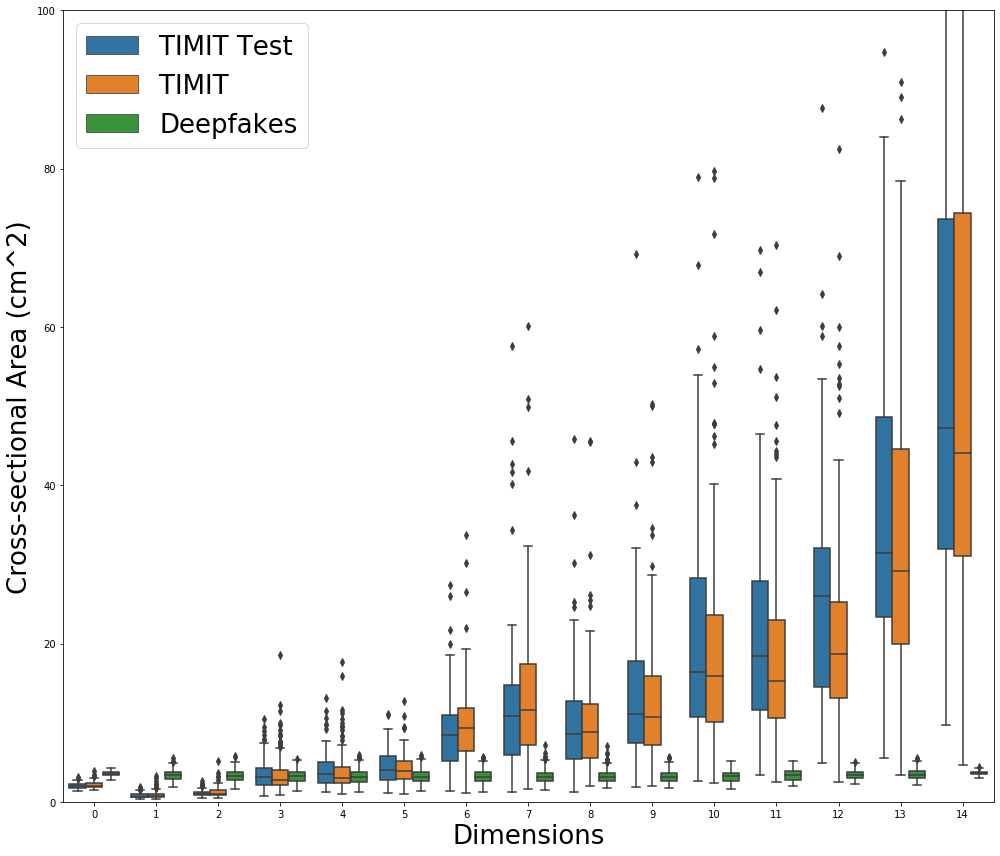

In [410]:
#for title, grp in df_dim[df_dim.label == 'aɪ--m'].groupby('label'):
#    if len(grp.dataset.unique()) == 3:
        
grp = df_dim[df_dim.label == 'd -- oʊ']
#relable
grp_fake = grp[grp.dataset == 'fakes']
grp_fake['dataset'] = 'Deepfakes'
grp_true = grp[grp.dataset == 'true']
grp_true['dataset'] = 'TIMIT'
grp_test = grp[grp.dataset == 'test']
grp_test['dataset'] = 'TIMIT Test'
grp = pd.concat([grp_fake, grp_true, grp_test])

hue_ord = ['TIMIT Test', 'TIMIT', 'Deepfakes']

plt.figure(figsize=(14, 12))
sns_fig = sns.boxplot(x='dimension', y='distro_mu', hue='dataset', hue_order = hue_ord, data=grp)
plt.ylim(0, 100)
#get counts of each label
fake_len = grp[(grp.dataset == 'TIMIT') & (grp.dimension == 0)].count()[0]
true_len = grp[(grp.dataset == 'TIMIT Test') & (grp.dimension == 0)].count()[0]
test_len = grp[(grp.dataset == 'Deepfakes') & (grp.dimension == 0)].count()[0]

plt.xlabel('Dimensions', fontsize=26)
plt.legend(fontsize=26)
plt.ylabel('Cross-sectional Area (cm^2)', fontsize=26)
plt.tight_layout()
#plt.title(title + '  [Counts -- true:' + str(true_len) + " -- test:" + str(test_len) + " -- fake:" + str(fake_len) + "]")
tmp = sns_fig.get_figure()
tmp.savefig('boxes_n_boats.pdf')
#break

In [395]:
tmp=grp.groupby(['dataset', 'dimension']).agg('mean').reset_index()
df_fakes = tmp[tmp.dataset == 'Deepfakes'].distro_mu.values
df_fakes = [np.sqrt(x / np.pi) for x in df_dia]
df_true = tmp[tmp.dataset == 'TIMIT'].distro_mu.values
df_true = [np.sqrt(x / np.pi) for x in df_true]
df_test = tmp[tmp.dataset == 'TIMIT Test'].distro_mu.values
df_test = [np.sqrt(x / np.pi) for x in df_test]

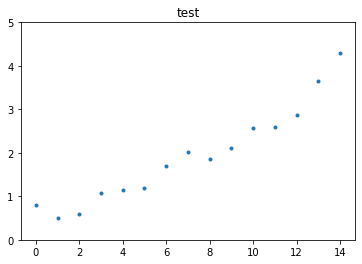

In [396]:
plt.plot(df_test, marker='.', linestyle='None')
plt.ylim(0, 5)
plt.title('test')
plt.savefig('test_tube.pdf')

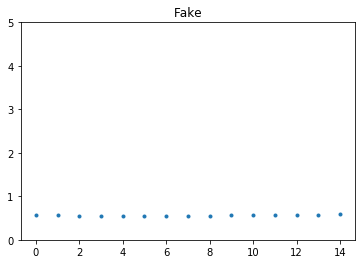

In [397]:
plt.plot(df_fakes, marker='.', linestyle='None')
plt.ylim(0, 5)
plt.title('Fake')
plt.savefig('fake_tube.pdf')

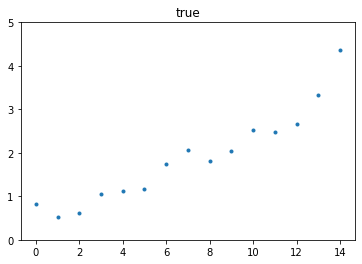

In [398]:
plt.plot(df_true, marker='.', linestyle='None')
plt.ylim(0, 5)
plt.title('true')
plt.savefig('true_tube.pdf')

# PCA 
* Transform data into correct shape
* Normalize data
* Principle Component Analysis

In [6]:
df_dim

,speaker_id,prev_index,sex,label,window,dimension,distro,word,filepath,dataset,distro_mu
0,FALK0,7943,f,aɪ -- k,0,0,[2.621544507090381],like,E:\SynologyDrive\Research\guesswho_new\guesswh...,true,2.621545
1,FALK0,7943,f,aɪ -- k,0,1,[1.608424605043254],like,E:\SynologyDrive\Research\guesswho_new\guesswh...,true,1.608425
2,FALK0,7943,f,aɪ -- k,0,2,[2.623770543013566],like,E:\SynologyDrive\Research\guesswho_new\guesswh...,true,2.623771
3,FALK0,7943,f,aɪ -- k,0,3,[4.3470195658177575],like,E:\SynologyDrive\Research\guesswho_new\guesswh...,true,4.347020
4,FALK0,7943,f,aɪ -- k,0,4,[3.1027577573091087],like,E:\SynologyDrive\Research\guesswho_new\guesswh...,true,3.102758
...,...,...,...,...,...,...,...,...,...,...,...
1006540,MVRW0,13225,f,ʌ -- ð,2,10,[9.467943567692936],another,E:\SynologyDrive\Research\guesswho_new\guesswh...,test,9.467944
1006541,MVRW0,13225,f,ʌ -- ð,2,11,[12.669971620515387],another,E:\SynologyDrive\Research\guesswho_new\guesswh...,test,12.669972
1006542,MVRW0,13225,f,ʌ -- ð,2,12,[15.855399852958179],another,E:\SynologyDrive\Research\guesswho_new\guesswh...,test,15.855400
1006543,MVRW0,13225,f,ʌ -- ð,2,13,[22.79933673331658],another,E:\SynologyDrive\Research\guesswho_new\guesswh...,test,22.799337


In [7]:
#Transform
#Just 1 window at at time
new_df_list = []
for keys, grp in tqdm(df_dim.groupby(['speaker_id', 'label', 'word', 'dataset', 'window', 'filepath']), position=0, leave=True):
    row = grp.iloc[0]
    new_row = {}
    new_row['speaker_id'] = row['speaker_id']
    new_row['label'] = row['label']
    new_row['window'] = row['window']
    new_row['word'] = row['word']
    new_row['dataset'] = row['dataset']
    new_row['filepath'] = row['filepath']
    
    for _, row in grp.iterrows():
        new_row[row['dimension']] = row['distro_mu']
    new_df_list.append(new_row)

df_flip_single = pd.DataFrame(new_df_list)

#all windows in bigram as features, so the feature space represents the whole bigram vector
"""======NOTE: this will require us to rewindow the data to make the feature space consistent==========="""



100%|█████████▉| 51405/51412 [01:42<00:00, 502.67it/s]


'======NOTE: this will require us to rewindow the data to make the feature space consistent==========='

In [146]:
#make speaker's between two dataset disjoint
df_true = df_flip_single[df_flip_single.dataset == 'true']
df_test = df_flip_single[df_flip_single.dataset == 'test']
df_fake = df_flip_single[df_flip_single.dataset == 'fakes']

test_speakers = df_test[df_test.speaker_id.isin(df_fake.speaker_id.unique())].speaker_id.drop_duplicates().sample(frac=0.5).values

df_test = df_test[df_test.speaker_id.isin(test_speakers)]
df_fake = df_fake[df_fake.speaker_id.isin(test_speakers)]
df_true = df_true[~df_true.speaker_id.isin(test_speakers)]

In [159]:
df_flip = pd.concat([df_test, df_true, df_fake], ignore_index=True)
#or
#df_flip = df_flip_single

### Normalize

In [160]:
#Normalize
features = list(range(0, 15))

#separating out features
x = df_flip.loc[:, features].values
x_true = df_flip[df_flip.dataset == 'true'].loc[:, features].values

#separate out data labels (true, test, fakes)
y = df_flip.loc[:, ['dataset']].values
z = df_flip.loc[:, ['label']].values
yy = df_flip.loc[:, ['filepath']].values

#standaraize the features
x = StandardScaler().fit_transform(x)
x_true = StandardScaler().fit_transform(x_true)

## PCA

### 2D

In [161]:
#optional filtering 
#make va

In [162]:
pca = PCA(n_components=2)
#train with just true
pca.fit(x_true)
principalComps = pca.transform(x)
#train with all 
#principalComps = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComps, columns=['pc_1', 'pc_2'])
df_final = pd.concat([df_pca, df_flip[['dataset']], df_flip[['label']], \
                     df_flip[['filepath']]], axis=1)

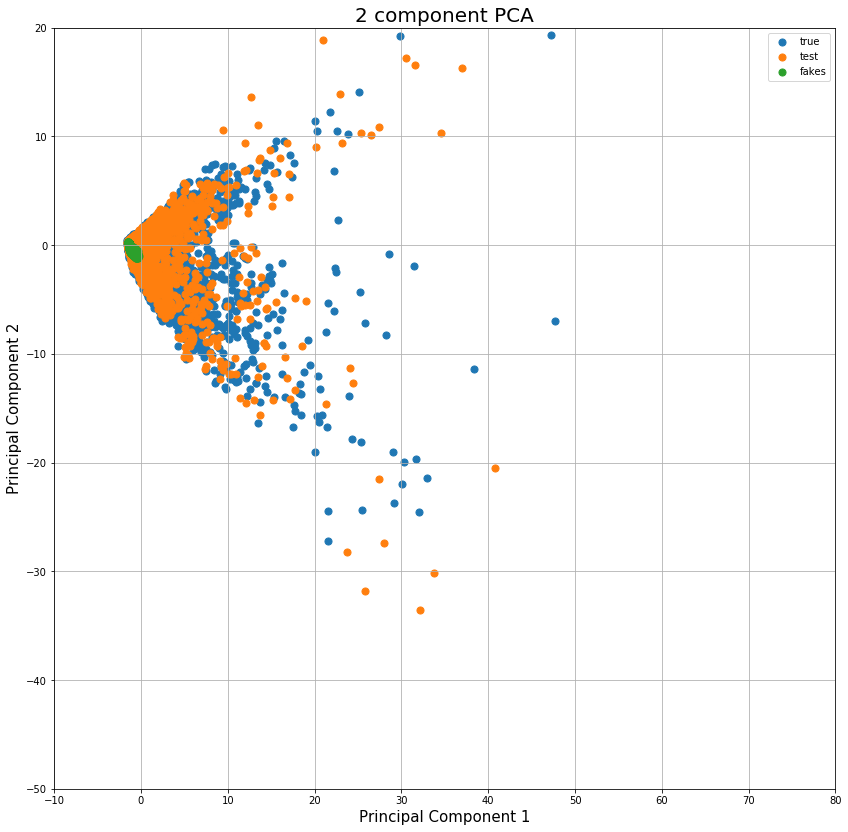

In [163]:
#visualize
fig = plt.figure(figsize = (14, 14))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['true', 'test', 'fakes']
colors = ['tab:blue', 'tab:orange', 'tab:green']
#targets = ['true', 'test', 'fakes']
#colors = ['tab:blue', 'tab:orange', 'tab:green']

for target, color in zip(targets, colors):
    indicesToKeep = df_final['dataset'] == target
    ax.scatter(df_final.loc[indicesToKeep, 'pc_1'], df_final.loc[indicesToKeep, 'pc_2'], 
              c = color, s = 50)
ax.legend(targets)
ax.set_xlim(-10, 80)
ax.set_ylim(-50, 20)
ax.grid()
plt.plot()
pca.explained_variance_ratio_
plt.savefig('theres_a_chance.png')

In [164]:
comp_matrix = pca.components_

In [165]:
true_disc = df_final[df_final.dataset=='true'].describe()
fake_disc = df_final[df_final.dataset=='fakes'].describe()
test_disc = df_final[df_final.dataset=='test'].describe()

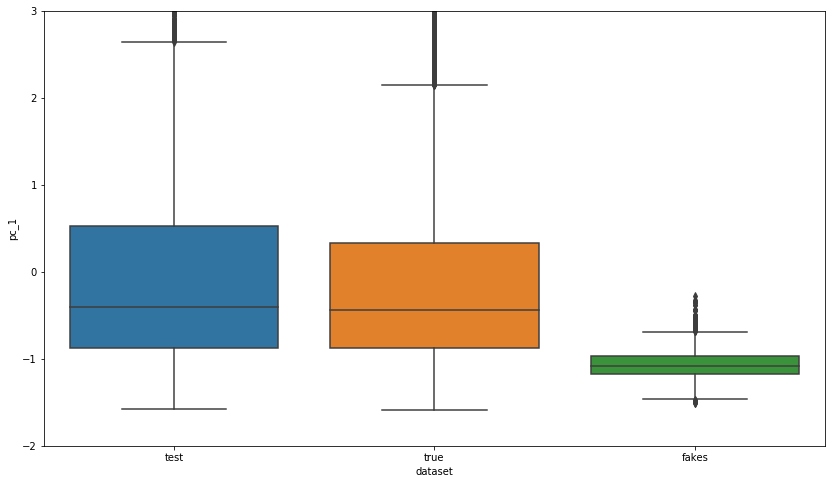

<Figure size 432x288 with 0 Axes>

In [183]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='dataset', y='pc_1', data=df_final)
plt.ylim(-2, 3)
plt.show()
plt.savefig('pc_1_box.png')

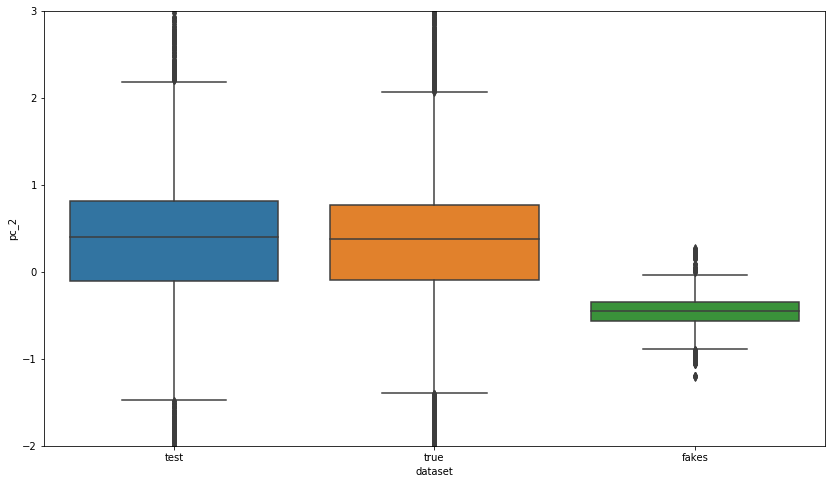

<Figure size 432x288 with 0 Axes>

In [184]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='dataset', y='pc_2', data=df_final)
plt.ylim(-2, 3)
plt.show()
plt.savefig('pc_2_box.png')

In [168]:
print('True')
display(true_disc)
print('fakes')
display(fake_disc)
print('test')
display(test_disc)

True


,pc_1,pc_2
count,15570.000000,15570.000000
mean,0.227143,0.104157
std,2.620910,1.824317
min,-1.592500,-27.208246
25%,-0.876163,-0.099027
50%,-0.442096,0.380609
75%,0.332781,0.767473
max,87.485880,31.362463


fakes


,pc_1,pc_2
count,5709.000000,5709.000000
mean,-1.067315,-0.448950
std,0.159655,0.187955
min,-1.511515,-1.214142
25%,-1.170620,-0.565086
50%,-1.078246,-0.448007
75%,-0.973228,-0.345802
max,-0.278974,0.276472


test


,pc_1,pc_2
count,5611.000000,5611.000000
mean,0.455655,0.167765
std,4.177568,2.658644
min,-1.575077,-33.588419
25%,-0.877097,-0.103341
50%,-0.401185,0.403003
75%,0.530021,0.810715
max,193.883707,92.454667


## Detector

In [169]:
df_final

,pc_1,pc_2,dataset,label,filepath
0,0.072232,0.785165,test,aɪ -- k,E:\SynologyDrive\Research\guesswho_new\guesswh...
1,-1.029355,-0.061391,test,aɪ -- k,E:\SynologyDrive\Research\guesswho_new\guesswh...
2,-0.855397,-0.293540,test,aɪ -- k,E:\SynologyDrive\Research\guesswho_new\guesswh...
3,-1.045293,-0.703616,test,aɪ -- k,E:\SynologyDrive\Research\guesswho_new\guesswh...
4,-1.139879,0.434180,test,aɪ -- k,E:\SynologyDrive\Research\guesswho_new\guesswh...
...,...,...,...,...,...
26885,-1.268988,-0.322434,fakes,ʃ -- ɑ,E:\SynologyDrive\Research\guesswho_new\guesswh...
26886,-1.128535,-0.355128,fakes,ʌ -- ð,E:\SynologyDrive\Research\guesswho_new\guesswh...
26887,-0.854302,-0.355465,fakes,ʌ -- ð,E:\SynologyDrive\Research\guesswho_new\guesswh...
26888,-1.062028,-0.411369,fakes,ʌ -- ð,E:\SynologyDrive\Research\guesswho_new\guesswh...


[]

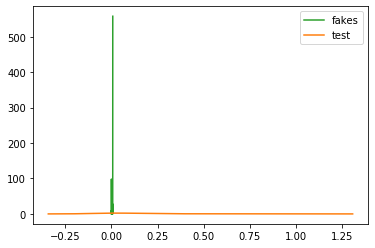

In [170]:
dist_pc_1_true = df_final[df_final.dataset == 'true']['pc_1'].values
dist_pc_2_true = df_final[df_final.dataset == 'true']['pc_2'].values

#fake test
p_values = []
for key, grp in df_final[df_final.dataset == 'fakes'].groupby('filepath'):
    dist_pc_1_test = grp.pc_1.values

    _, p_val =ks_2samp(dist_pc_1_true, dist_pc_1_test)   
    p_values.append(p_val)
p_values_fakes_1 = p_values

#test test
p_values = []
for key, grp in df_final[df_final.dataset == 'test'].groupby('filepath'):
    dist_pc_1_test = grp.pc_1.values

    _, p_val =ks_2samp(dist_pc_1_true, dist_pc_1_test)
    p_values.append(p_val)
p_values_test_1 = p_values

sns.distplot(p_values_fakes_1, hist=False, label='fakes', color='tab:green')
sns.distplot(p_values_test_1,  hist=False, label='test', color='tab:orange')
#plt.xscale('log')
plt.legend()
plt.plot()

[]

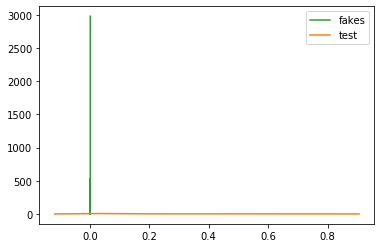

In [171]:
dist_pc_1_true = df_final[df_final.dataset == 'true']['pc_1'].values
dist_pc_2_true = df_final[df_final.dataset == 'true']['pc_2'].values

#fake test
p_values = []
for key, grp in df_final[df_final.dataset == 'fakes'].groupby('filepath'):
    dist_pc_2_test = grp.pc_2.values

    _, p_val =ks_2samp(dist_pc_2_true, dist_pc_2_test)   
    p_values.append(p_val)
p_values_fakes_2 = p_values

#test test
p_values = []
for key, grp in df_final[df_final.dataset == 'test'].groupby('filepath'):
    dist_pc_2_test = grp.pc_2.values

    _, p_val =ks_2samp(dist_pc_2_true, dist_pc_2_test)
    p_values.append(p_val)
p_values_test_2 = p_values

sns.distplot(p_values_fakes_2, hist=False, label='fakes', color='tab:green')
sns.distplot(p_values_test_2,  hist=False, label='test', color='tab:orange')
#plt.xscale('log')
plt.legend()
plt.plot()

In [172]:
print('========= PC 1 =============')
print(stats.describe(p_values_test_1))
print(stats.describe(p_values_fakes_1))
print('========= PC 2 =============')
print(stats.describe(p_values_test_2))
print(stats.describe(p_values_fakes_2))

========= PC 1 =============
DescribeResult(nobs=66, minmax=(2.428481606142807e-19, 0.9657670535070307), mean=0.20118125645083332, variance=0.08651986443855017, skewness=1.3470195087653831, kurtosis=0.37467790398677625)
DescribeResult(nobs=51, minmax=(2.135666141620617e-89, 0.007437756781063689), mean=0.00014583836867290562, variance=1.0847103123124604e-06, skewness=6.929646455628164, kurtosis=46.019999999999946)
========= PC 2 =============
DescribeResult(nobs=66, minmax=(3.024637356821677e-09, 0.7876445054211348), mean=0.10052560427959466, variance=0.02882341619799498, skewness=2.665498932790455, kurtosis=7.13910775452214)
DescribeResult(nobs=51, minmax=(6.492420365083757e-96, 0.001392709128234566), mean=2.7308022206898403e-05, variance=3.803213167896819e-08, skewness=6.929646455628168, kurtosis=46.019999999999996)


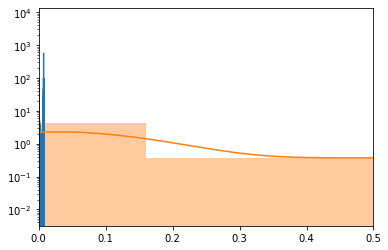

In [173]:
sns.distplot(p_values_fakes_1)
sns.distplot(p_values_test_1)

plt.xlim(0, 0.5)
plt.yscale('log')

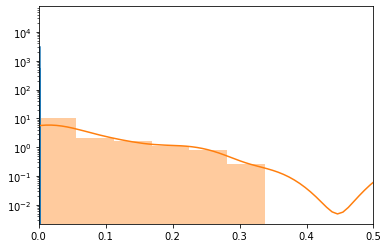

In [174]:
sns.distplot(p_values_fakes_2)
sns.distplot(p_values_test_2)

plt.xlim(0, 0.5)
plt.yscale('log')

In [175]:
#just trying a sweep 
result_k_sweep = []
for k in tqdm(np.arange(1e-25, 0.5, 1e-6), position=0, leave=True):
    #find classification for test values
    results_test1 = []
    for p_val in p_values_test_1:
        if p_val < k:
            results_test1.append(True)
        else:
            results_test1.append(False)
    
    results_test2 = []
    for p_val in p_values_test_2:
        if p_val < k:
            results_test2.append(True)
        else:
            results_test2.append(False)
        
    #find classification for fake values
    results_fake1 = []
    for p_val in p_values_fakes_1:
        if p_val < k:
            results_fake1.append(True)
        else:
            results_fake1.append(False)
    
    results_fake2 = []
    for p_val in p_values_fakes_2:
        if p_val < k:
            results_fake2.append(True)
        else:
            results_fake2.append(False)
    result_k_sweep.append([k, results_test1, results_test2, results_fake1, results_fake2])

100%|██████████| 500000/500000 [00:18<00:00, 26532.15it/s]


In [176]:
results = []
for curr_result in result_k_sweep:
    k, rt1, rt2, rf1, rf2 = curr_result
    # real test values, these should be classified as false (negative)
    false_positives_1 = rt1.count(True)
    true_negatives_1 = rt1.count(False)

    false_positives_2 = rt2.count(True)
    true_negatives_2 = rt2.count(False)

    # fake test values, these should be classified as true (positve)
    true_positives_1 = rf1.count(True)
    false_negatives_1 = rf1.count(False)

    true_positives_2 = rf2.count(True)
    false_negatives_2 = rf2.count(False)

    #calc results
    if k == 0:
        tpr_1 = 0
        tpr_2 = 0

        fpr_1 = 0
        fpr_2 = 0

        precision_1 = 0
        precision_2 = 0
    else:
        tpr_1 = true_positives_1 / (true_positives_1 + false_negatives_1)
        tpr_2 = true_positives_2 / (true_positives_2 + false_negatives_2)

        fpr_1 = false_positives_1 / (false_positives_1 + true_negatives_1)
        fpr_2 = false_positives_2 / (false_positives_2 + true_negatives_2)

        precision_1 = true_positives_1 / (true_positives_1 + false_positives_1)
        precision_2 = true_positives_2 / (true_positives_2 + false_positives_2)

    ind_results = {'k': k, 'fpr_1': fpr_1, 'fpr_2': fpr_2, 'tpr_1': tpr_1, 'tpr_2': tpr_2, 'prec_1':precision_1, 'prec_2':precision_2}
    results.append(ind_results)

In [177]:
k_res = pd.DataFrame(results)
k_res = k_res.drop([0])

(0, 1)

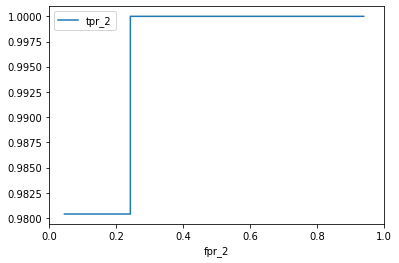

In [178]:
k_res.plot(x='fpr_2', y='tpr_2')
plt.xlim(0,1)

(0, 1)

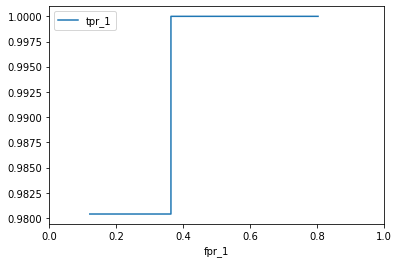

In [179]:
k_res.plot(x='fpr_1', y='tpr_1')
plt.xlim(0,1)

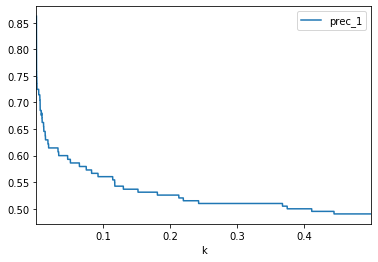

In [180]:
k_res.plot(x = 'k', y='prec_1')

In [109]:
k_res

,k,fpr_1,fpr_2,tpr_1,tpr_2,prec_1,prec_2
1,0.000001,0.095238,0.081633,0.979798,0.989899,0.873874,0.890909
2,0.000002,0.108844,0.088435,0.979798,0.989899,0.858407,0.882883
3,0.000003,0.108844,0.088435,0.979798,0.989899,0.858407,0.882883
4,0.000004,0.115646,0.108844,0.979798,0.989899,0.850877,0.859649
5,0.000005,0.115646,0.115646,0.979798,0.989899,0.850877,0.852174
...,...,...,...,...,...,...,...
499995,0.499995,0.891156,0.911565,1.000000,1.000000,0.430435,0.424893
499996,0.499996,0.891156,0.911565,1.000000,1.000000,0.430435,0.424893
499997,0.499997,0.891156,0.911565,1.000000,1.000000,0.430435,0.424893
499998,0.499998,0.891156,0.911565,1.000000,1.000000,0.430435,0.424893


## 3D

In [519]:
pca_3 = PCA(n_components=3)
principalComps = pca_3.fit_transform(x)
df_pca_3 = pd.DataFrame(data = principalComps, columns=['pc_1', 'pc_2', 'pc_3'])
df_final_3 = pd.concat([df_pca_3, df_flip_single[['dataset']]], axis=1)

array([0.70139846, 0.16776326, 0.06645588])

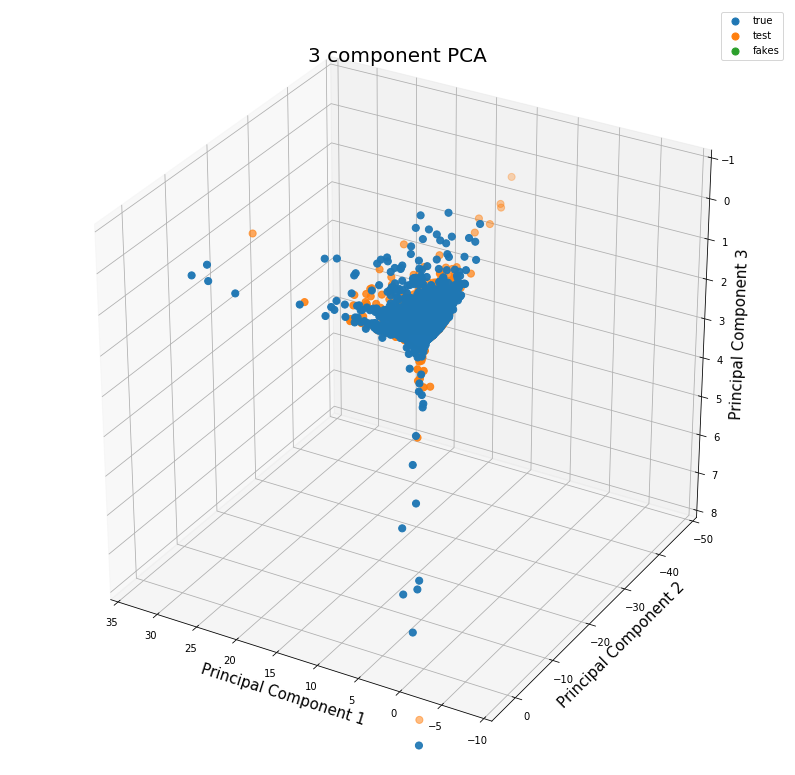

In [525]:
#visualize
fig = plt.figure(figsize = (14, 14))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

#targets = ['fakes']
#colors = ['tab:green']

targets = ['true', 'test', 'fakes']
colors = ['tab:blue', 'tab:orange', 'tab:green']

for target, color in zip(targets, colors):
    indicesToKeep = df_final_3['dataset'] == target
    ax.scatter(df_final_3.loc[indicesToKeep, 'pc_1'], df_final_3.loc[indicesToKeep, 'pc_2'], 
               df_final_3.loc[indicesToKeep, 'pc_3'],
              c = color, s = 50)
ax.legend(targets)
ax.set_xlim(35, -10)
ax.set_ylim(5, -50)
ax.set_zlim(8, -1)
ax.grid()
pca_3.explained_variance_ratio_

## Hadi's code is gross...

In [192]:
#confusion matrix math for a one sided k value
def cm_oneside(df, k_value, less_than=True):
    """This function does not handle labels filter. It will apply the k value to whatever 
    is in the df and evaluate the TPR, FPR, recall, and precision on all dimensionally labeled
    columns (0-14) in the df.
    
    Remember, positive is the detecter has marked this sample as a synthetic piece of auto
    """
    if less_than:
        #conditioned positives 
        counts = list(df.apply(lambda row: [row[i] < k_value for i in range(0, 15)], axis=1))
        conditioned_pos = [dim_count.count(True) for dim_count in list(zip(*counts))]

        #condiitioned negatives
        conditioned_neg = df.count()[0] - conditioned_pos
        
        #really positive
        real_pos = df[df.dataset == 'fakes'].count()[0]
        
        #really negative
        real_neg = df[df.dataset != 'fakes'].count()[0]

        #false positive
        counts = list(df[df.dataset != 'fakes'].apply(lambda row: [row[i] < k_value for i in range(0, 15)], axis=1))
        false_pos = [dim_count.count(True) for dim_count in list(zip(*counts))]

        #true positives 
        counts = list(df[df.dataset == 'fakes'].apply(lambda row: [row[i] < k_value for i in range(0, 15)], axis=1))
        true_pos = [dim_count.count(True) for dim_count in list(zip(*counts))]

        tpr = true_pos / real_pos        #true positive rate or recall
        fpr = false_pos / real_neg       #false positive rate or fall-out
        precision = [x / (x + y) for x, y in zip(true_pos, false_pos)]  
    else:
        #conditioned positives 
        counts = list(df.apply(lambda row: [row[i] > k_value for i in range(0, 15)], axis=1))
        conditioned_pos = [dim_count.count(True) for dim_count in list(zip(*counts))]

        #condiitioned negatives
        conditioned_neg = df.count()[0] - conditioned_pos
        
        #really positive
        real_pos = df[df.dataset == 'fakes'].count()[0]
        
        #really negative
        real_neg = df[df.dataset != 'fakes'].count()[0]

        #false positive
        counts = list(df[df.dataset != 'fakes'].apply(lambda row: [row[i] > k_value for i in range(0, 15)], axis=1))
        false_pos = [dim_count.count(True) for dim_count in list(zip(*counts))]

        #true positives 
        counts = list(df[df.dataset == 'fakes'].apply(lambda row: [row[i] > k_value for i in range(0, 15)], axis=1))
        true_pos = [dim_count.count(True) for dim_count in list(zip(*counts))]

        tpr = true_pos / real_pos        #true positive rate or recall
        fpr = false_pos / real_neg       #false positive rate or fall-out
        precision = [x / (x + y) for x, y in zip(true_pos, false_pos)]
    return tpr, fpr, precision

def cm_twoside(df, k_values):
    """This function does not handle labels filter. It will apply the k value to whatever 
    is in the df and evaluate the TPR, FPR, recall, and precision on all dimensionally labeled
    columns (0-14) in the df.
    
    Remember, positive is the detecter has marked this sample as a synthetic piece of auto
    
    k_values = (low, high) --> low < mark as false < high
    """
    #conditioned positives 
    counts = list(df.apply(lambda row: [(row[i] < k_value[1]) and (row[i] > k_value[0]) for i in range(0, 15)], axis=1))
    conditioned_pos = [dim_count.count(True) for dim_count in list(zip(*counts))]

    #condiitioned negatives
    conditioned_neg = df.count()[0] - conditioned_pos

    #really positive
    real_pos = df[df.dataset == 'fakes'].count()[0]

    #really negative
    real_neg = df[df.dataset != 'fakes'].count()[0]

    #false positive
    counts = list(df[df.dataset != 'fakes'].apply(lambda row: [(row[i] < k_value[1]) and (row[i] > k_value[0])\
                                                  for i in range(0, 15)], axis=1))
    false_pos = [dim_count.count(True) for dim_count in list(zip(*counts))]

    #true positives 
    counts = list(df[df.dataset == 'fakes'].apply(lambda row: [(row[i] < k_value[1]) and (row[i] > k_value[0])\
                                                               for i in range(0, 15)], axis=1))
    true_pos = [dim_count.count(True) for dim_count in list(zip(*counts))]

    tpr = true_pos / real_pos        #true positive rate or recall
    fpr = false_pos / real_neg       #false positive rate or fall-out
    precision = [x / (x + y) for x, y in zip(true_pos, false_pos)]
    
    return tpr, fpr, precision

In [658]:
cm_oneside(df_flip_single[df_flip_single.label == 'aɪ -- k'], 3)

(array([0.02970297, 0.24752475, 0.31683168, 0.32673267, 0.30693069,
        0.24752475, 0.21782178, 0.20792079, 0.17821782, 0.14851485,
        0.12871287, 0.05940594, 0.02970297, 0.11881188, 0.        ]),
 array([0.71891892, 0.83783784, 0.72972973, 0.45405405, 0.38378378,
        0.45945946, 0.37837838, 0.27567568, 0.20540541, 0.12432432,
        0.0972973 , 0.05405405, 0.03783784, 0.05405405, 0.02162162]),
 [0.022058823529411766,
  0.1388888888888889,
  0.19161676646706588,
  0.28205128205128205,
  0.30392156862745096,
  0.22727272727272727,
  0.2391304347826087,
  0.2916666666666667,
  0.32142857142857145,
  0.39473684210526316,
  0.41935483870967744,
  0.375,
  0.3,
  0.5454545454545454,
  0.0])

/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


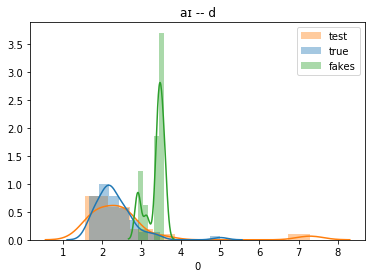

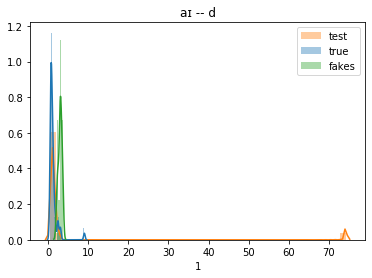

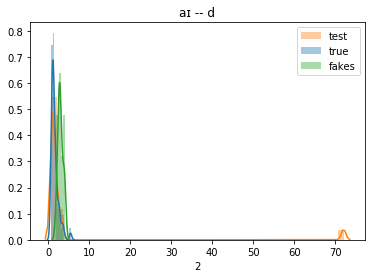

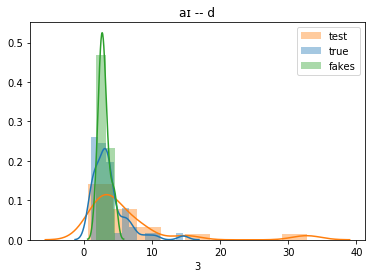

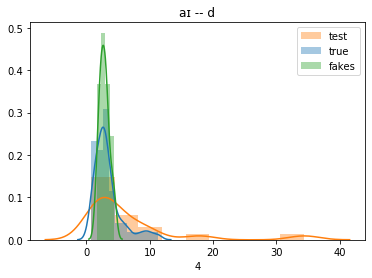

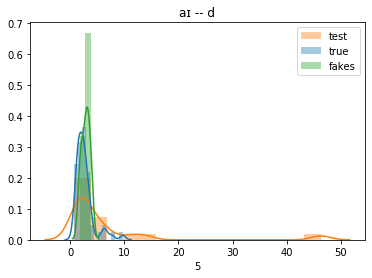

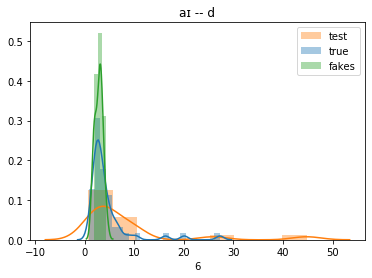

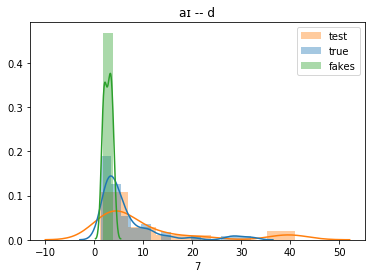

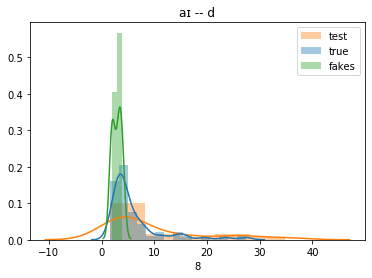

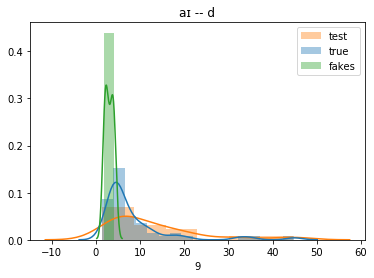

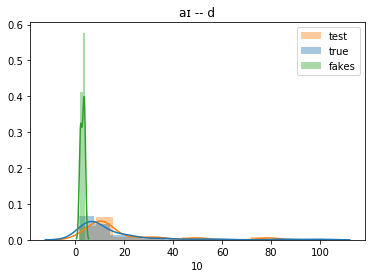

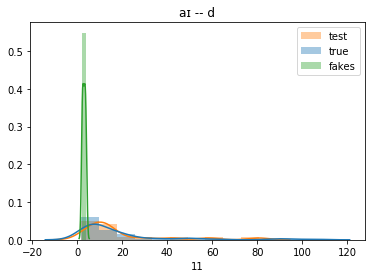

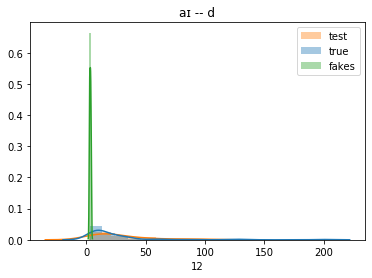

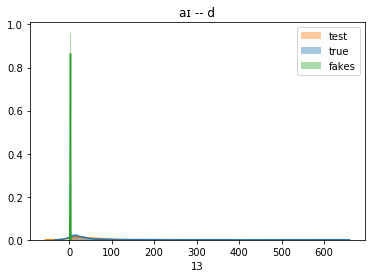

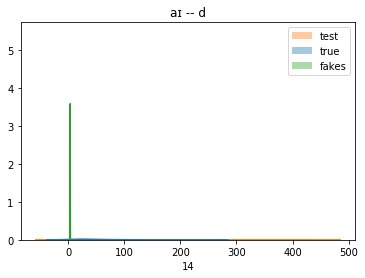

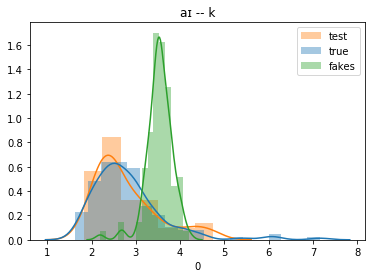

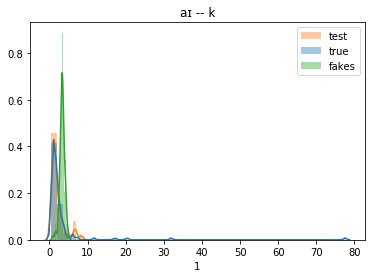

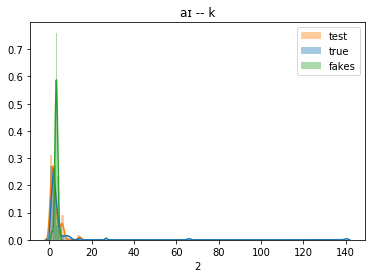

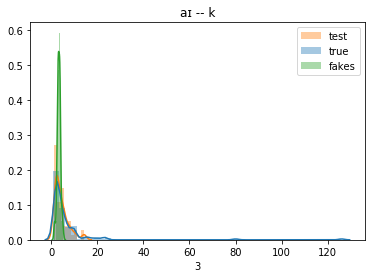

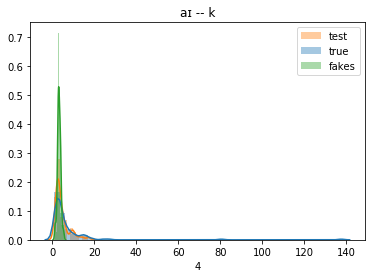

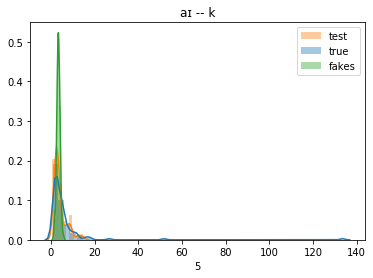

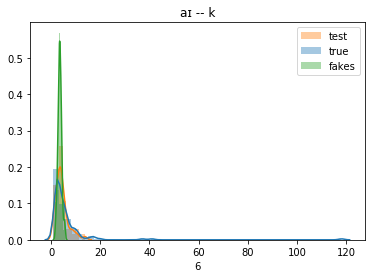

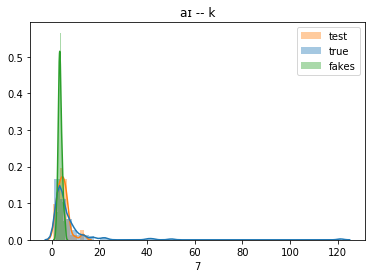

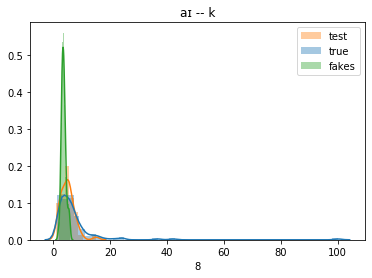

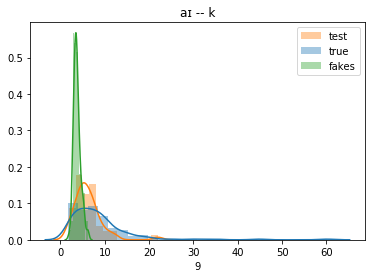

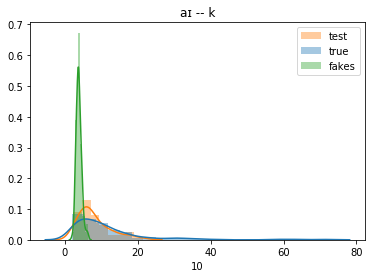

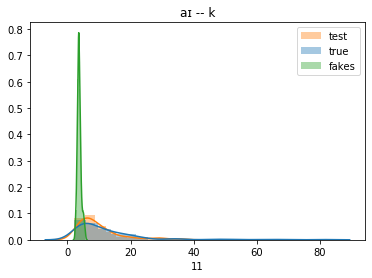

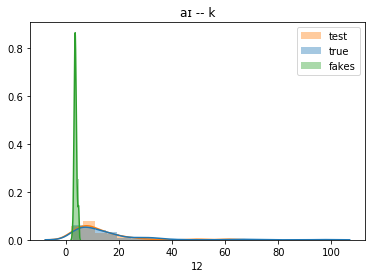

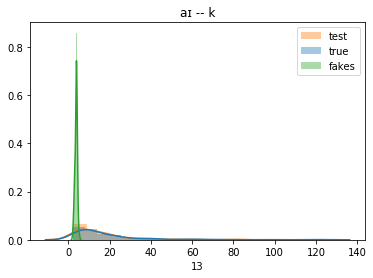

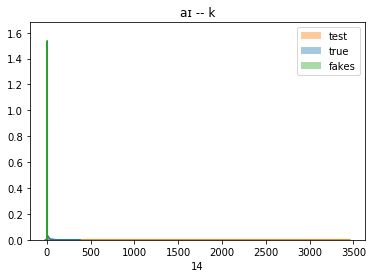

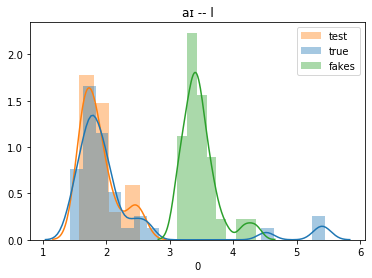

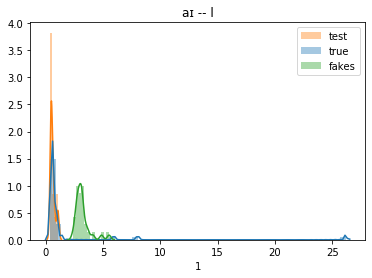

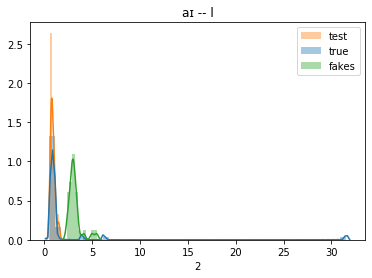

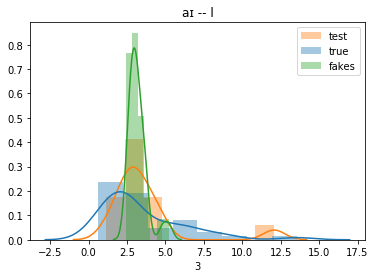

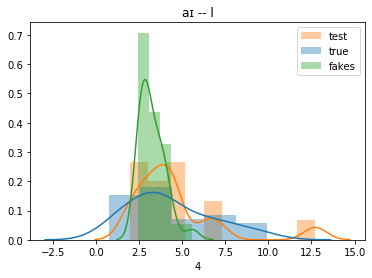

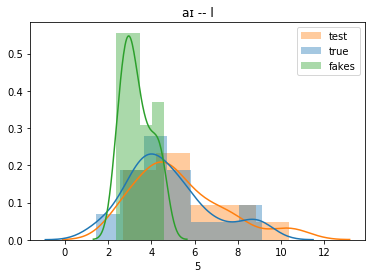

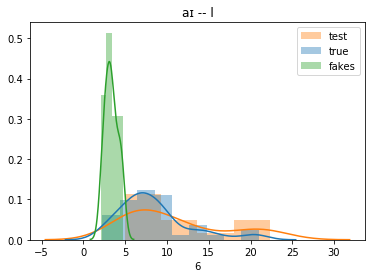

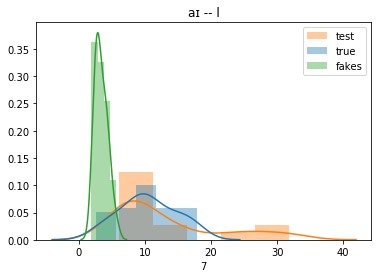

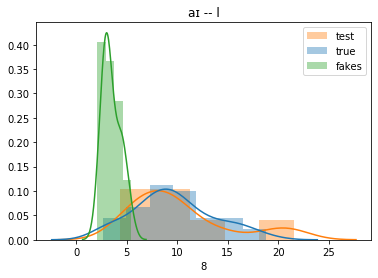

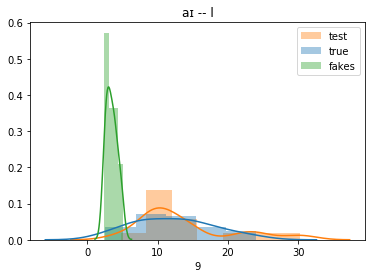

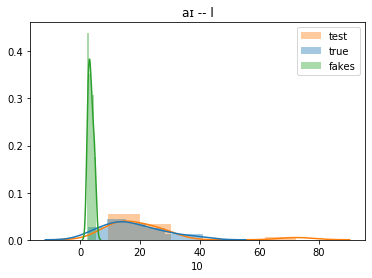

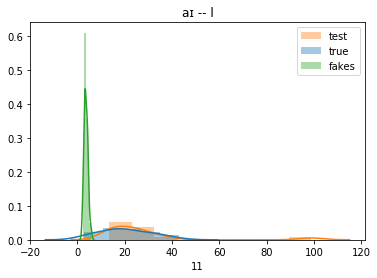

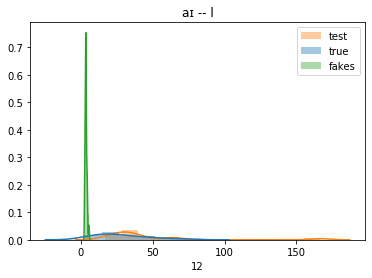

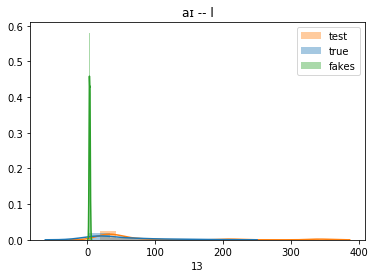

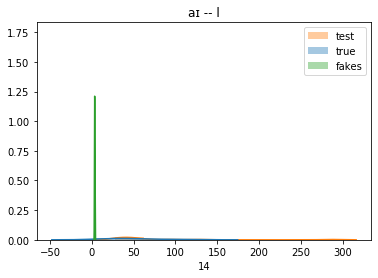

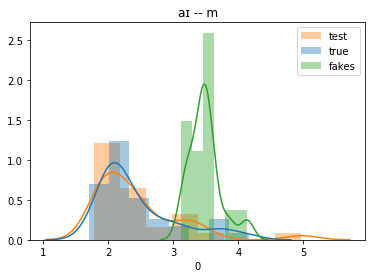

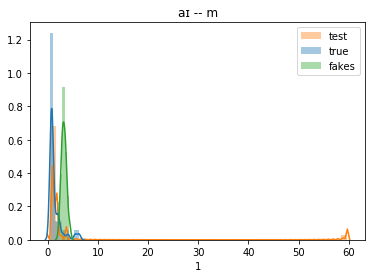

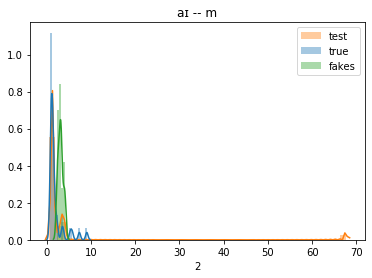

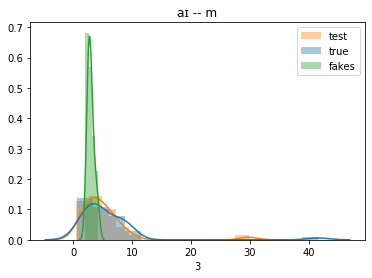

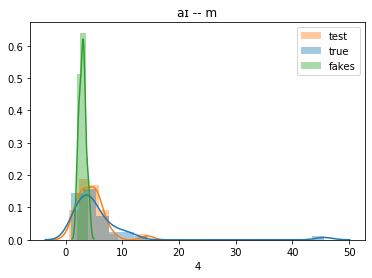

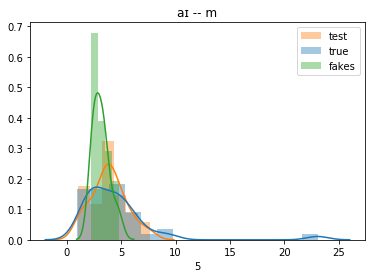

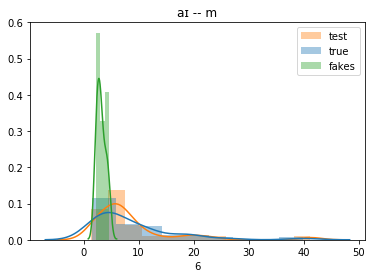

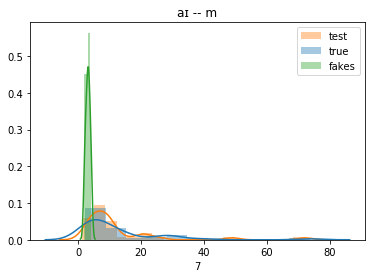

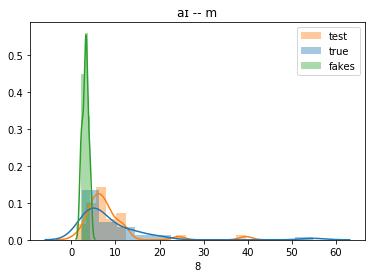

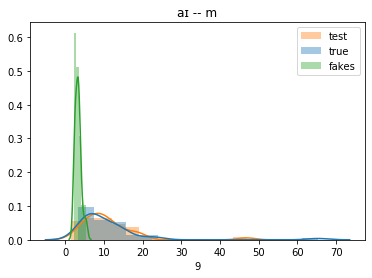

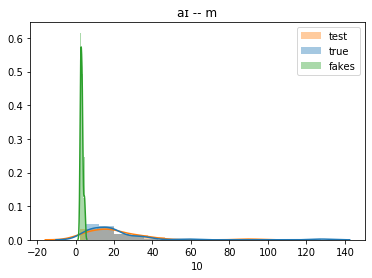

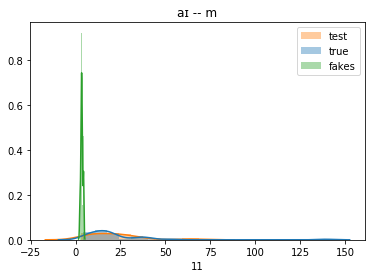

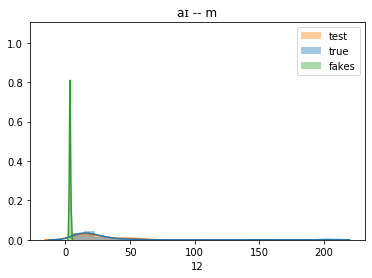

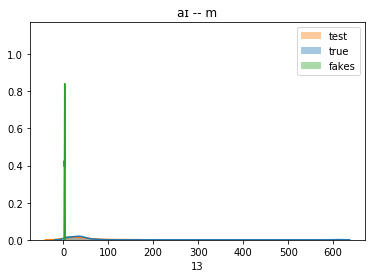

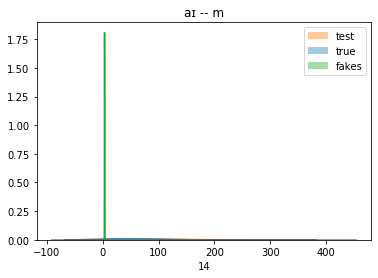

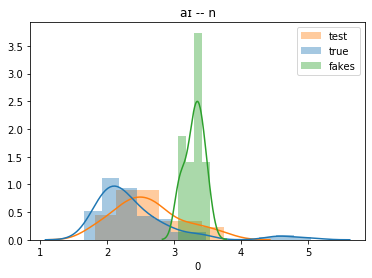

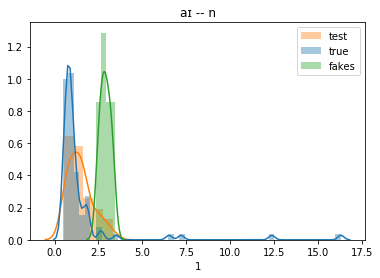

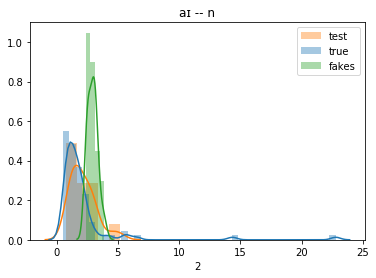

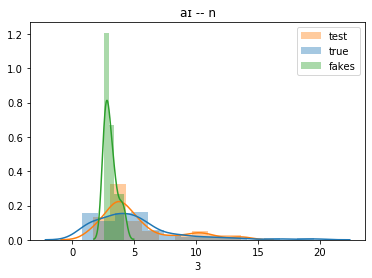

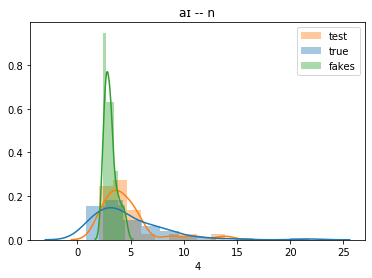

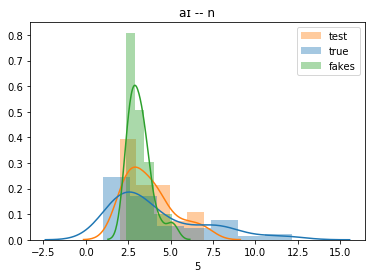

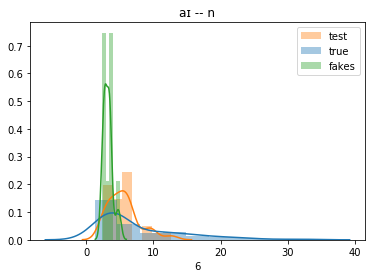

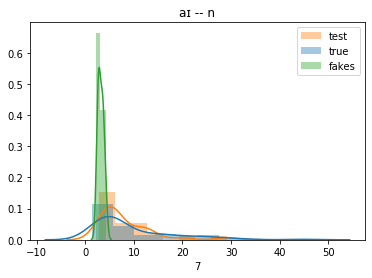

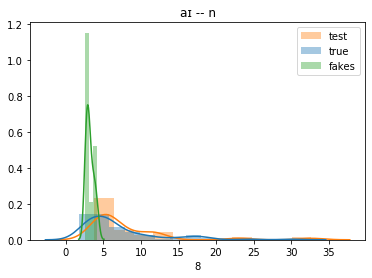

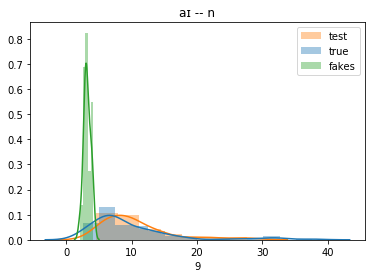

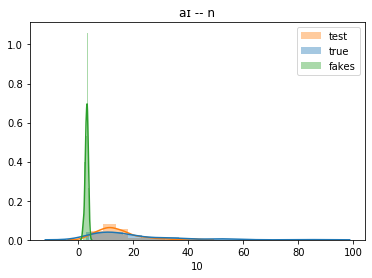

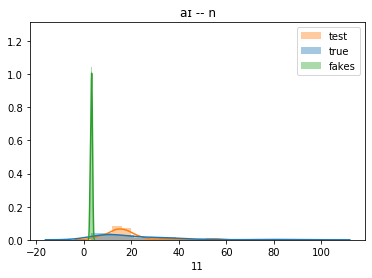

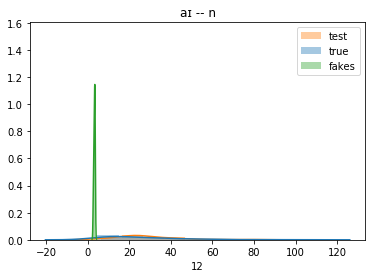

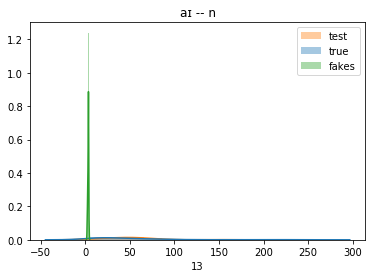

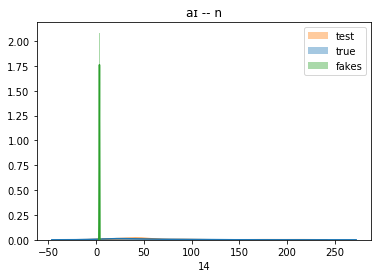

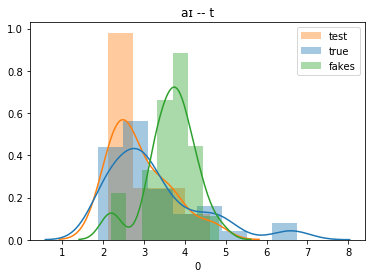

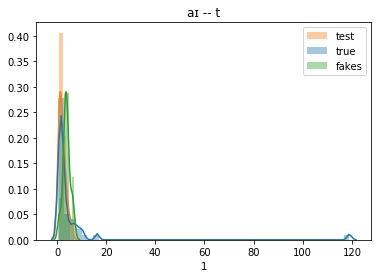

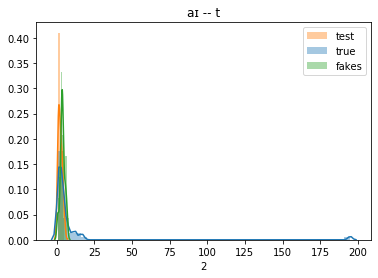

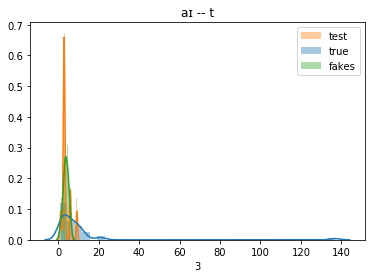

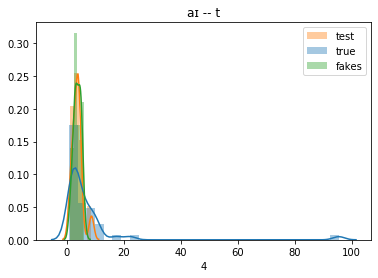

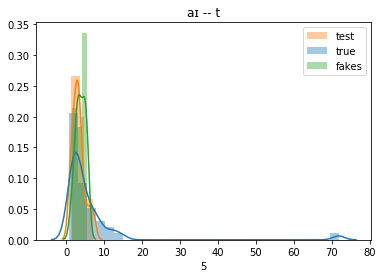

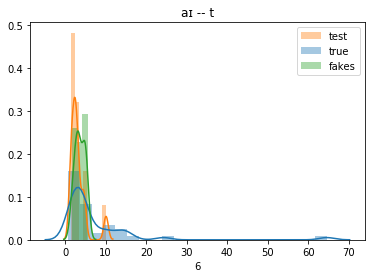

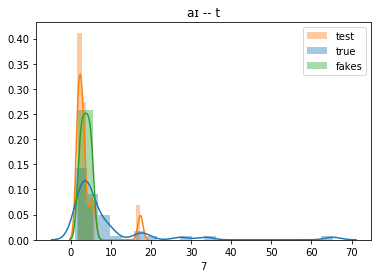

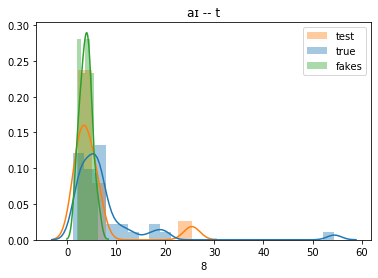

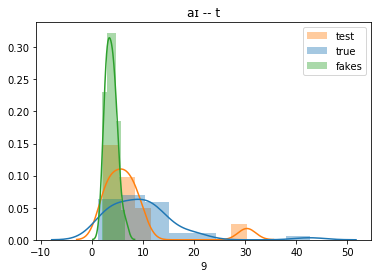

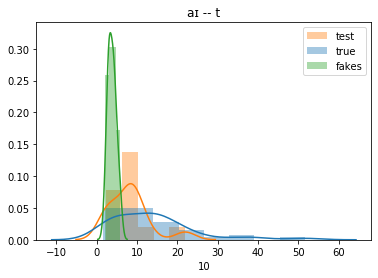

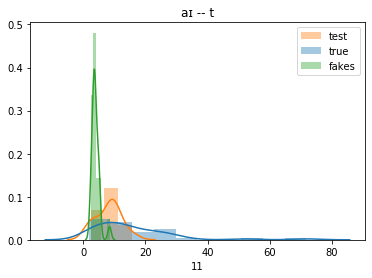

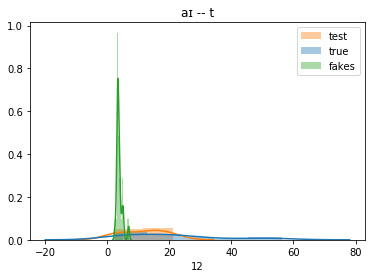

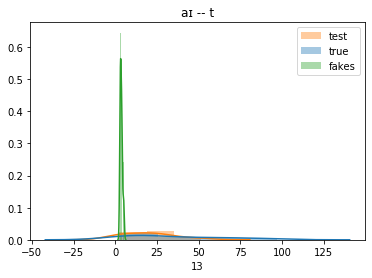

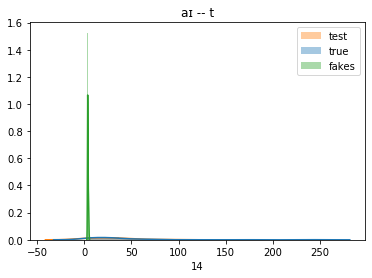

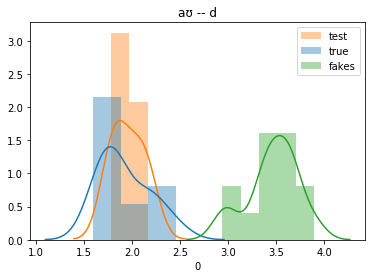

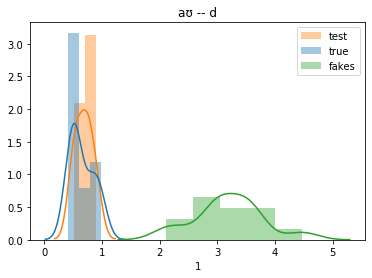

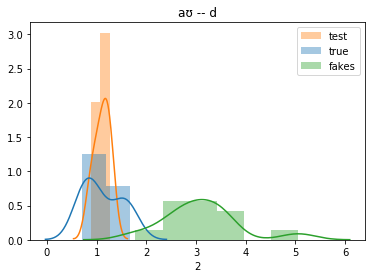

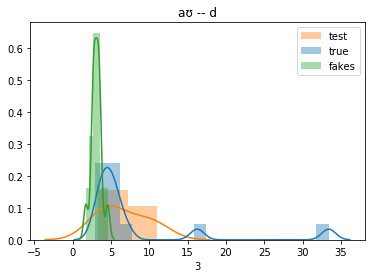

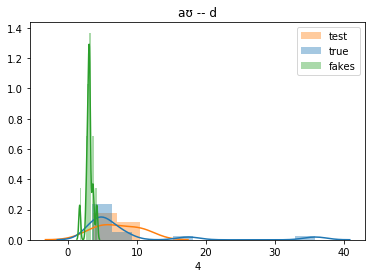

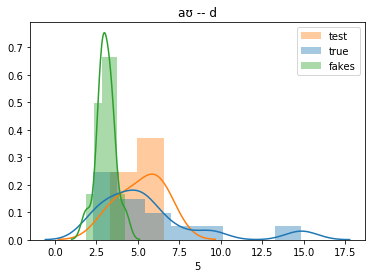

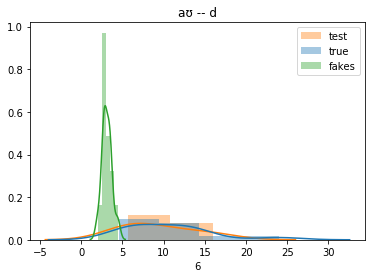

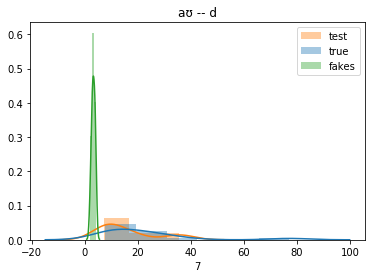

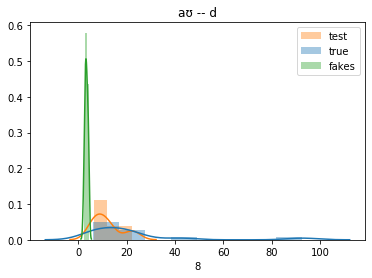

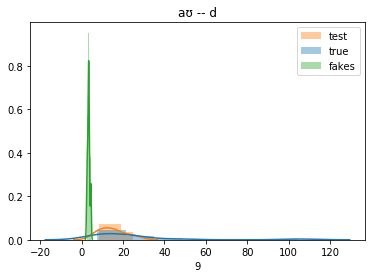

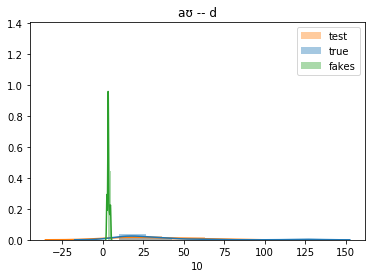

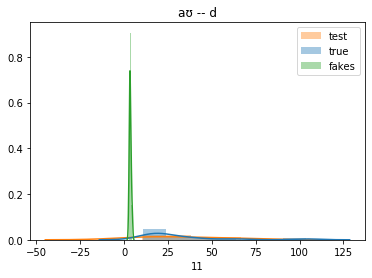

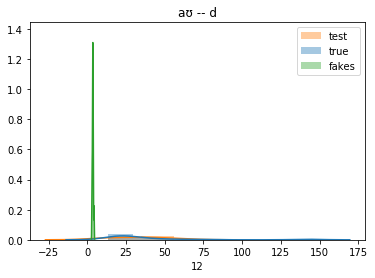

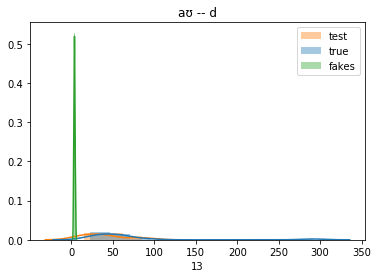

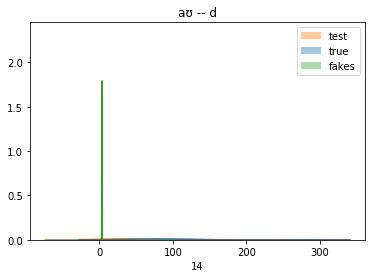

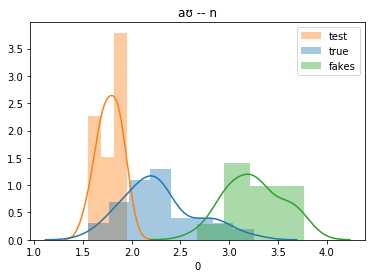

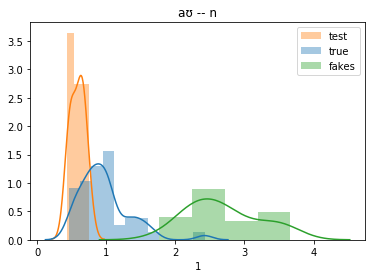

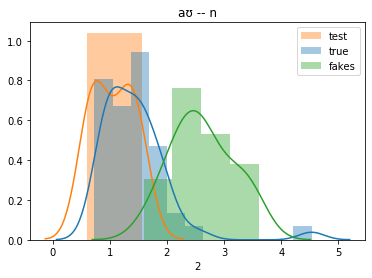

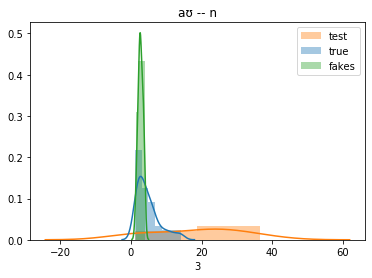

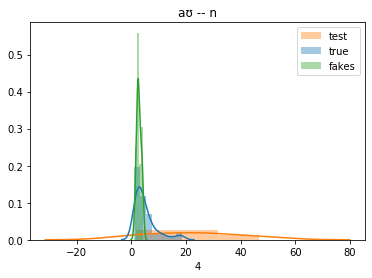

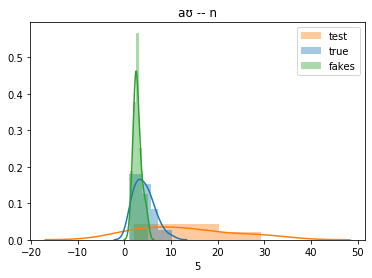

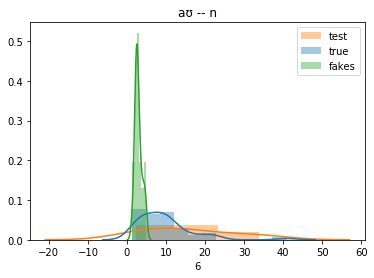

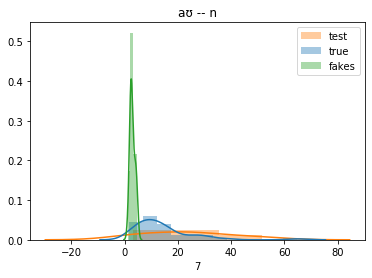

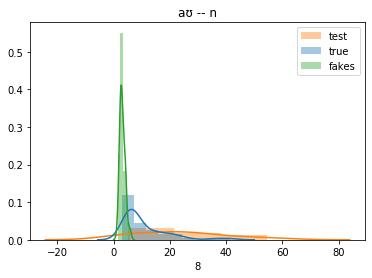

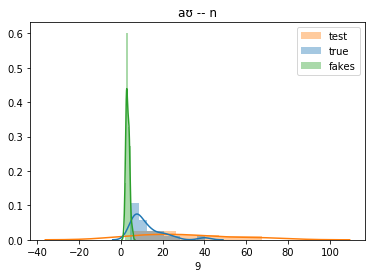

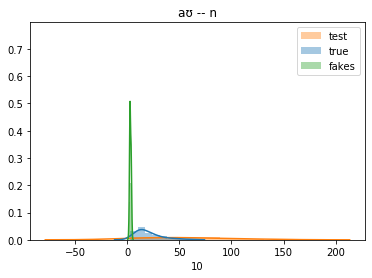

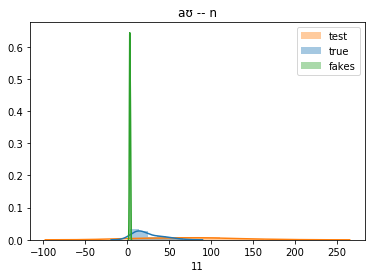

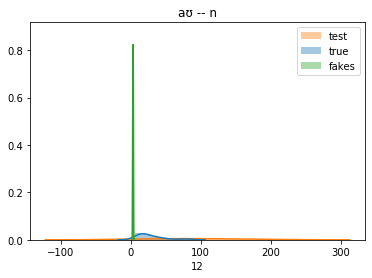

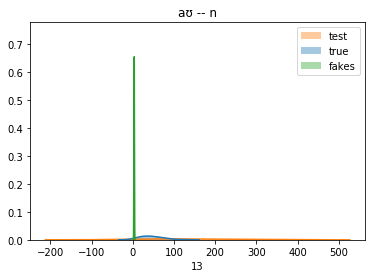

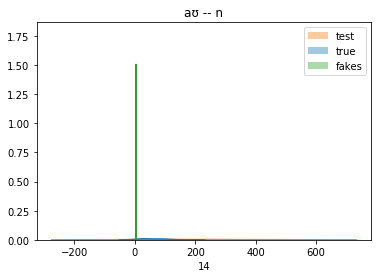

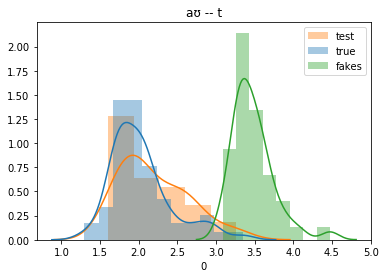

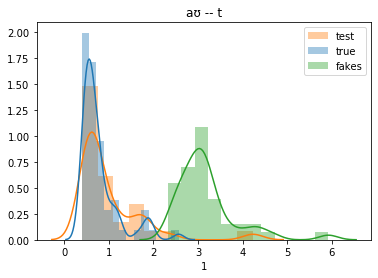

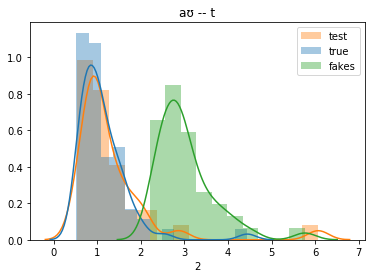

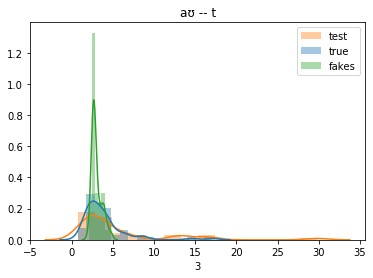

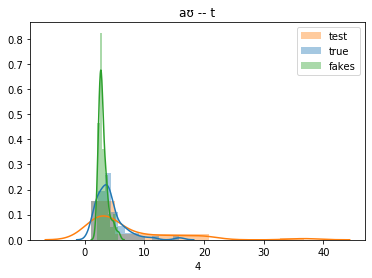

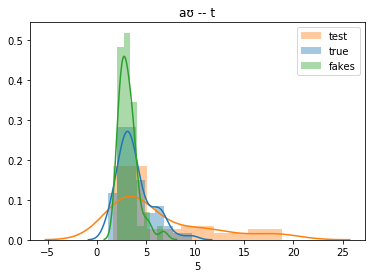

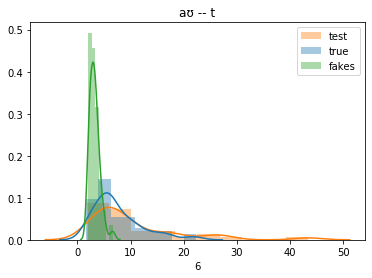

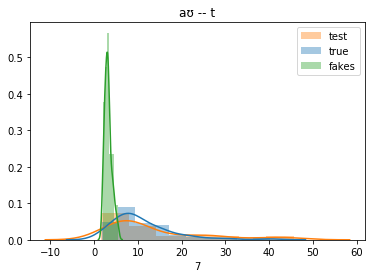

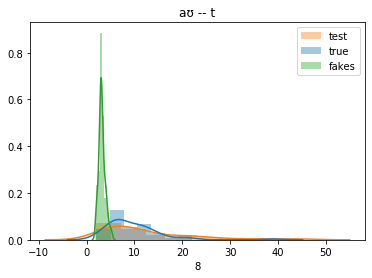

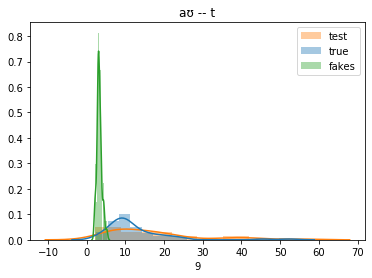

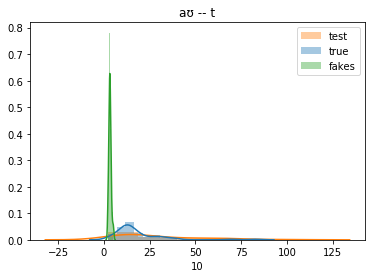

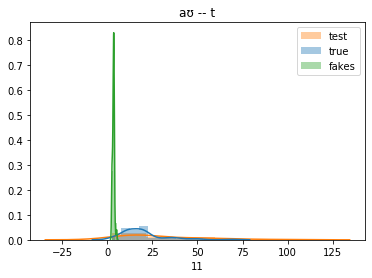

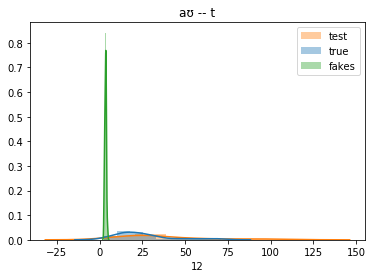

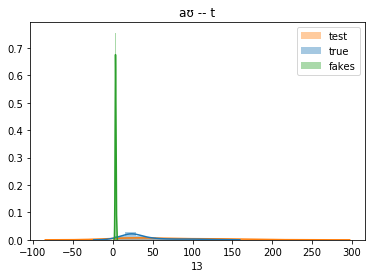

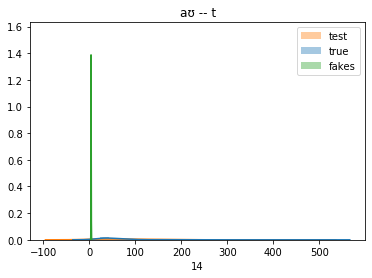

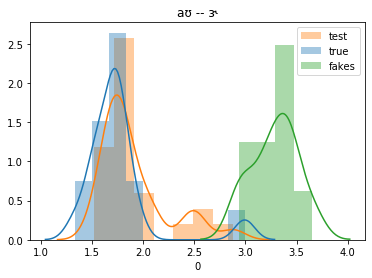

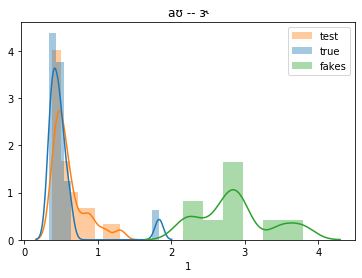

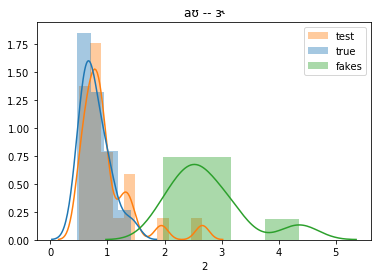

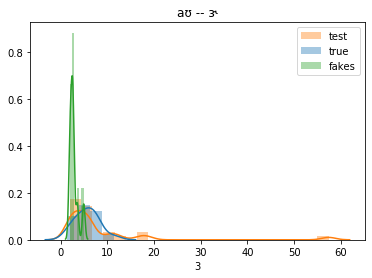

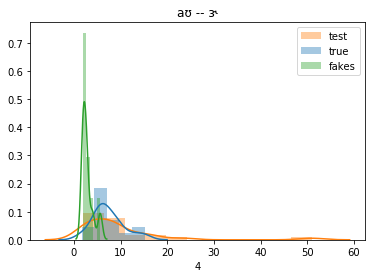

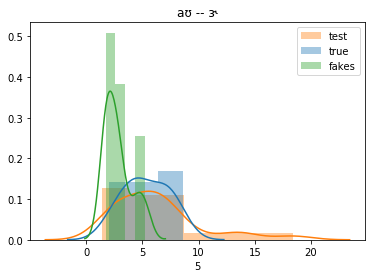

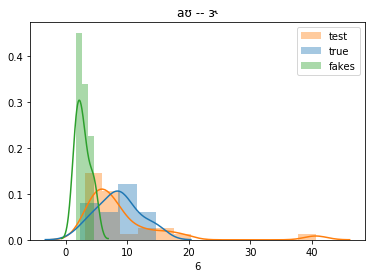

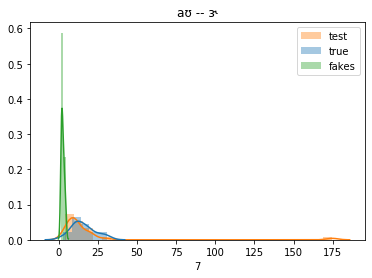

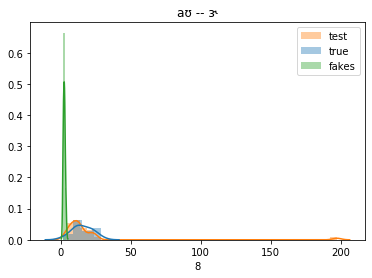

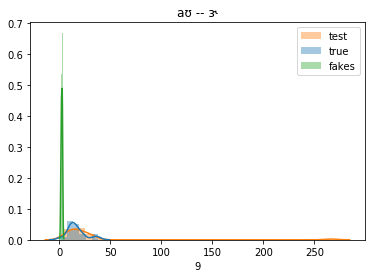

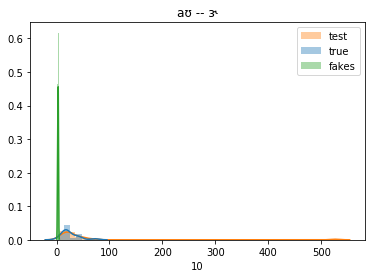

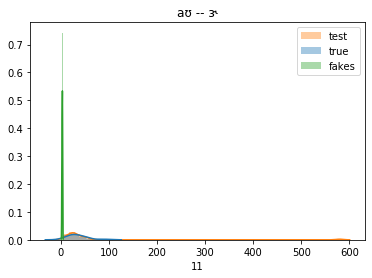

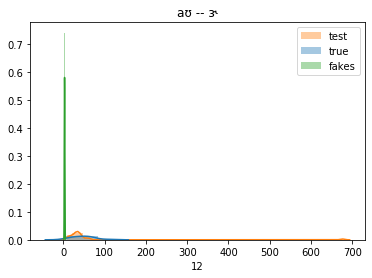

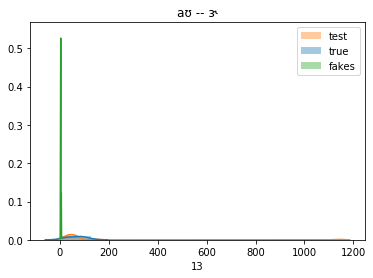

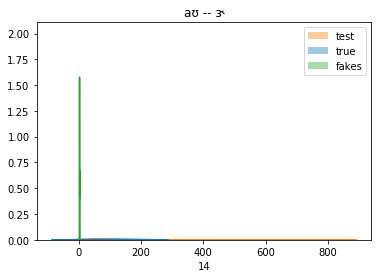

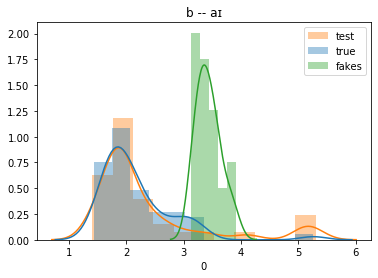

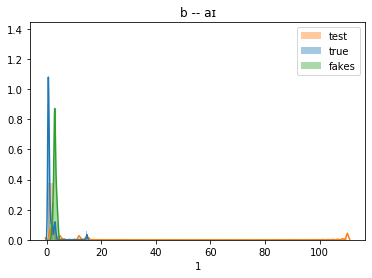

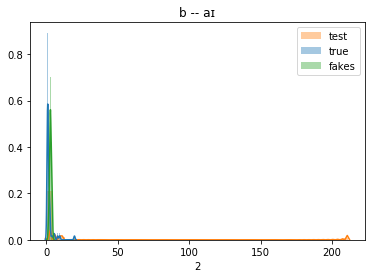

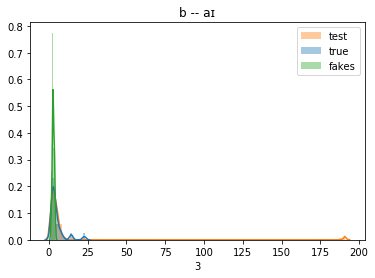

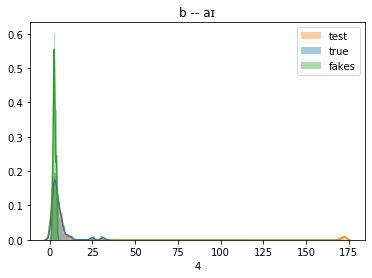

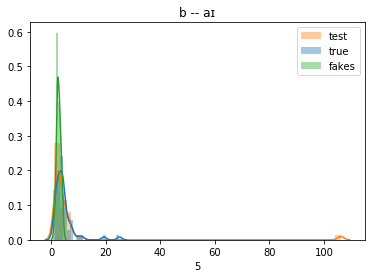

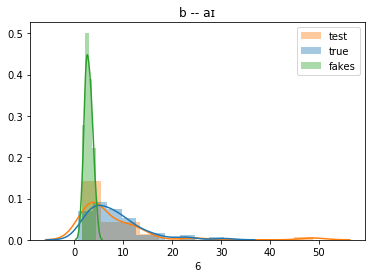

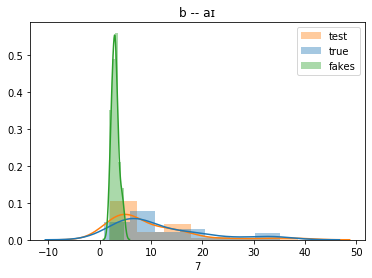

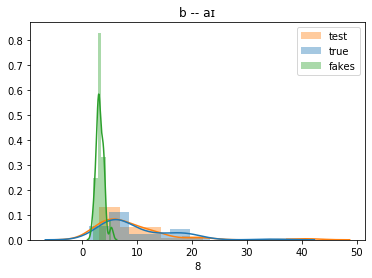

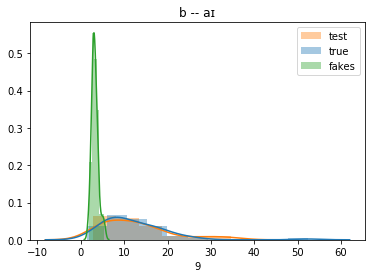

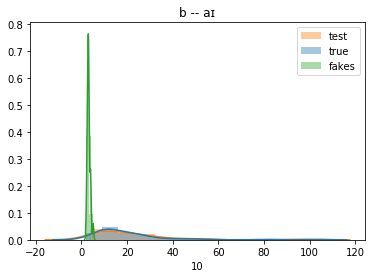

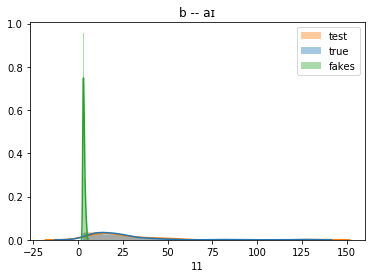

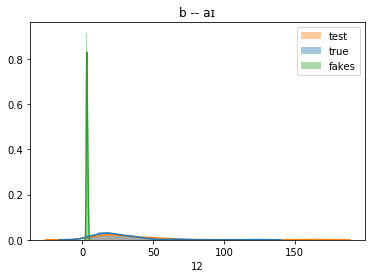

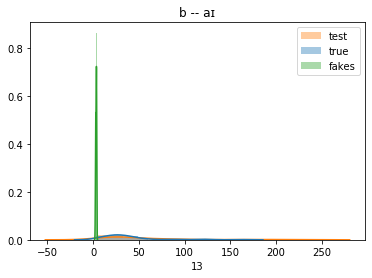

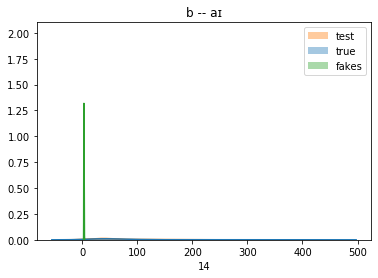

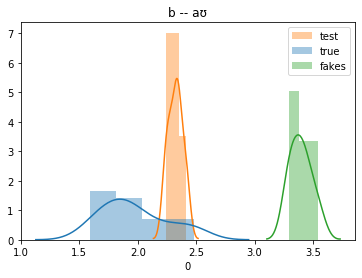

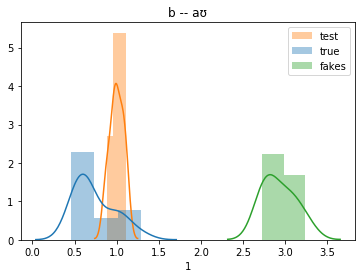

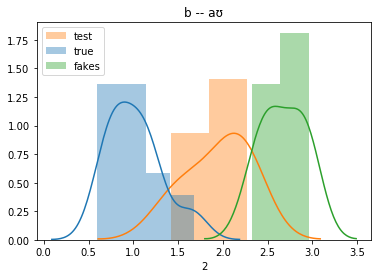

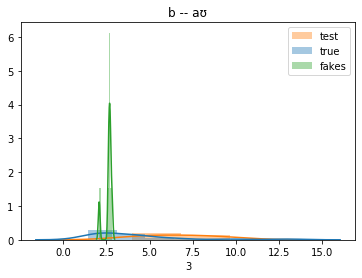

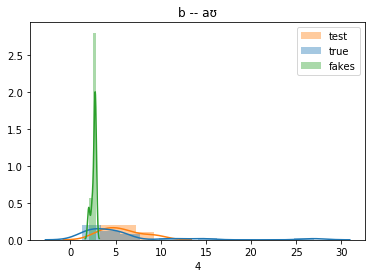

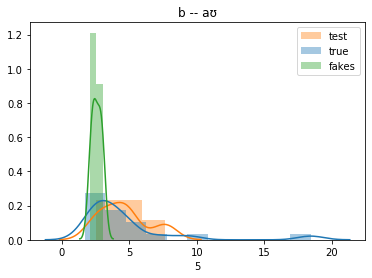

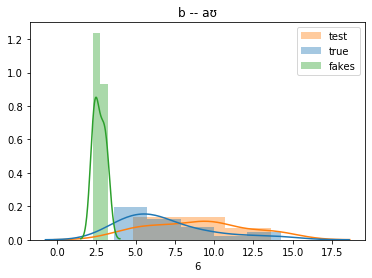

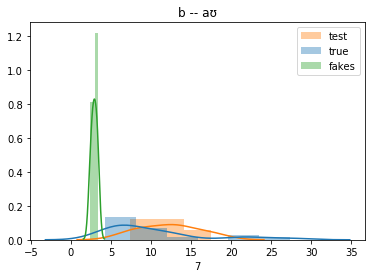

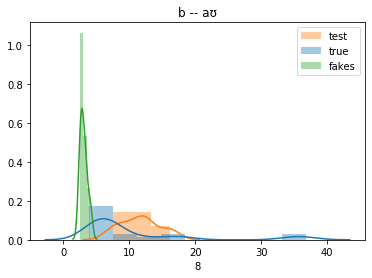

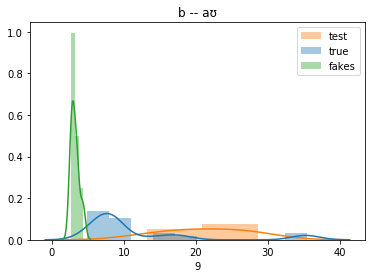

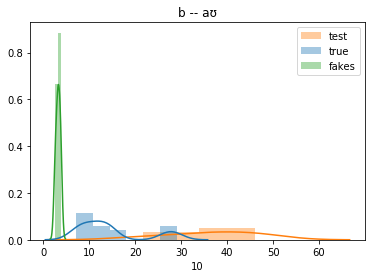

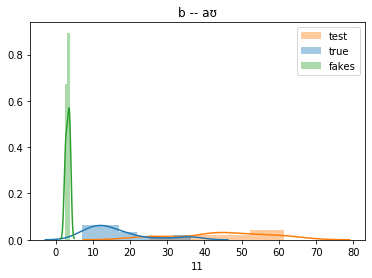

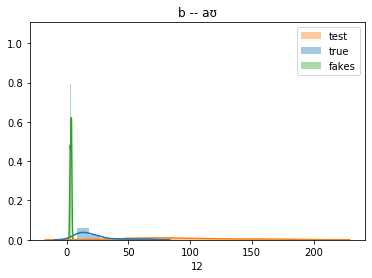

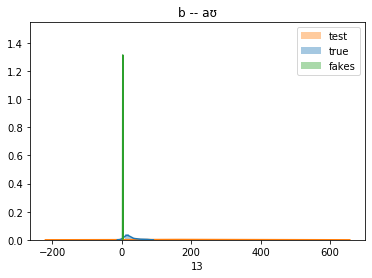

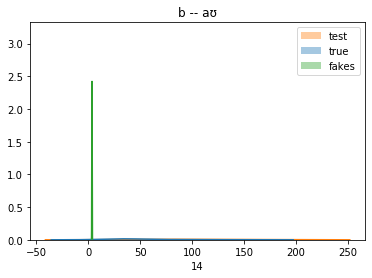

In [616]:
count = 0
for label_key, grp in df_flip_single.groupby('label'):
    increment = False
    for dim in range(0, 15):
        #check that this grp has all datasets
        if len(grp.dataset.unique()) == 3:
            plt.figure()
            for d_set in ['test', 'true', 'fakes']:
                colors = {'test':'tab:orange', 'true':'tab:blue', 'fakes':'tab:green'}
                sns.distplot(grp[grp.dataset == d_set][dim], color=colors[d_set], label=d_set)
            plt.title(label_key)
            plt.legend()
            plt.plot()
            increment = True
    if count > 10:
        break
    elif increment:
        count += 1

## To Hadi

In [300]:
#connect to mongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["exploration"]

#rtf
table = db['asv_spoof_true_16']

"""============REAL TIME FAKES============================="""
#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))

"""
df_timit_train = augment_wrapper(df)
augment_wrapper throws an error everytime and I'm not sure
why, just copy nad pasting this here makes it work fine...
"""
key_columns = ['speaker_id', 'sex', 'label', 'window_index']
df = add_words(df)
grouped_df = df.groupby(key_columns)

distros_list = []
print("Creating true...")
with Pool(4) as p:
    for x in tqdm(p.imap_unordered(augment, grouped_df), total=len(grouped_df),
                 position=0, leave=True):
        distros_list.append(x)
df_dim_train = pd.concat(distros_list)

df_dim_train['dataset'] = 'true'
df_dim_train['attack_type'] = '--'

df_dim_train['speaker_id'] = df_dim_train.apply(lambda row: row['filepath'][-33:-26], axis=1)

/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating true...


100%|██████████| 6618/6618 [01:30<00:00, 73.21it/s]


In [310]:
df_dim_train.columns

Index(['speaker_id', 'prev_index', 'sex', 'label', 'window', 'dimension',
       'distro', 'word', 'filepath', 'dataset', 'attack_type'],
      dtype='object')

In [312]:
df_dim_fakes.columns

Index(['speaker_id', 'prev_index', 'sex', 'label', 'window', 'dimension',
       'distro', 'word', 'filepath', 'dataset', 'attack_type'],
      dtype='object')

In [308]:
#rtf
table = db['asv_spoof_gentle_fake_16']

"""============REAL TIME FAKES============================="""
#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))

"""
df_timit_train = augment_wrapper(df)
augment_wrapper throws an error everytime and I'm not sure
why, just copy nad pasting this here makes it work fine...
"""
key_columns = ['speaker_id', 'sex', 'label', 'window_index']
df = add_words(df)
grouped_df = df.groupby(key_columns)

distros_list = []
print("Creating fakes...")
with Pool(4) as p:
    for x in tqdm(p.imap_unordered(augment, grouped_df), total=len(grouped_df),
                 position=0, leave=True):
        distros_list.append(x)
df_dim_fakes = pd.concat(distros_list)

#final additions
#label groups
df_dim_fakes['dataset'] = 'fakes'

/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating fakes...


100%|██████████| 4979/4979 [01:09<00:00, 71.95it/s]


In [311]:
#fix crappy labeling of this set
df_dim_fakes['attack_type'] = df_dim_fakes.apply(lambda row: row['filepath'][-20:-17], axis=1)
df_dim_fakes['speaker_id'] = df_dim_fakes.apply(lambda row: row['filepath'][-28:-21], axis=1)

In [288]:
#add labels to fake data
#df_dim_fakes = fake_data_add_labels(df_dim_fakes, df_dim_train)

df_dim = pd.concat([df_dim_train, df_dim_fakes], ignore_index=True)

df_dim['distro_mu'] = df_dim.apply(lambda row: np.mean(row['distro']), axis=1)

/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [316]:
df_all_explode = df_dim.explode('distro')

In [318]:
df_all_explode.to_csv('all_labeled_exploded.csv')

In [366]:
df_dim_fakes[(df_dim_fakes.speaker_id == 'MGAF0') & (df_dim_fakes.dataset=='fakes')][['word']].drop_duplicates()

,word
16470,don't
16605,that


In [563]:
np.mean(df_dim[df_dim.dataset=='fakes'].groupby('speaker_id')['label'].nunique())

42.56818181818182

In [350]:
from ast import literal_eval
df_tmp = pd.read_csv('all_labeled_exploded.csv', sep=',',
       dtype = {
           'spaker_id' : np.str,
           'prev_index': np.int,
           'sex': np.str,
           'abel': np.str,
           'window': np.int,
           'dimension': np.int,
           'distro': np.float64,
           'word': np.str,
           'dataset': np.str,
           'distro_mu': np.str
       })

In [444]:
#rtf
table = db['real_time_gentle_16_2']

"""============REAL TIME FAKES============================="""
#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))
print('Creating real time fake set')
"""
df_timit_train = augment_wrapper(df)
augment_wrapper throws an error everytime and I'm not sure
why, just copy nad pasting this here makes it work fine...
"""
key_columns = ['speaker_id', 'sex', 'label', 'window_index']
df_raw = df
df = add_words(df)
grouped_df = df.groupby(key_columns)

distros_list = []
print("Creating real time fakes...")
with Pool(4) as p:
    for x in tqdm(p.imap_unordered(augment, grouped_df), total=len(grouped_df),
                 position=0, leave=True):
        distros_list.append(x)
df_dim_fakes = pd.concat(distros_list)

Creating real time fake set


/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating real time fakes...


100%|██████████| 10150/10150 [02:08<00:00, 78.89it/s]


In [445]:
df_dim_fakes[(df_dim_fakes.speaker_id == 'MGAF0')][['word']].drop_duplicates()

,word
0,like
0,down
0,out
0,by
0,radiation
0,shielding
0,radio
0,keep
0,carry
0,cut


In [446]:
df[(df.speaker_id == 'MGAF0')][['word']].drop_duplicates()

,word
4383,an
4385,ask
4392,carry
4406,don't
4411,like
4418,me
4421,oily
4435,rag
4448,that
4465,to


In [378]:
df_raw

,_id,cross_sect_est,label,filepath,speaker_id,start_bigram,end_bigram,window_start,window_end,window_index,sex
0,5eac74a4b03f2e2ecb87d73e,"[3.5251513376293695, 3.078296052724147, 2.7629...",æ -- z,E:\SynologyDrive\Research\guesswho_new\guesswh...,FCYL0,640,2240,1058,1623,0,f
1,5eac74a48e03435bf428536d,"[3.279025199939641, 2.7986460632936794, 2.9490...",æ -- z,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,640,2240,1058,1623,0,f
2,5eac74a570b467e02230f1a0,"[3.7672801945529217, 3.600834483965197, 3.5405...",æ -- z,E:\SynologyDrive\Research\guesswho_new\guesswh...,MJEB0,640,2240,1058,1623,0,f
3,5eac74a542acb4375d04cbee,"[3.4847450386422776, 3.118652669692213, 2.8521...",æ -- z,E:\SynologyDrive\Research\guesswho_new\guesswh...,MRWS0,640,2240,1058,1623,0,f
4,5eac74a5b470d0cdf499aa86,"[3.793063853054943, 3.8752683745347043, 3.5492...",æ -- z,E:\SynologyDrive\Research\guesswho_new\guesswh...,FMJB0,640,2240,1058,1623,0,f
...,...,...,...,...,...,...,...,...,...,...,...
13295,5eac8355b03f2e2ecb87e1b1,"[3.5874812888993937, 3.390493072672227, 2.9576...",ð -- ɛ,E:\SynologyDrive\Research\guesswho_new\guesswh...,MVRW0,79840,80160,80328,80893,1,f
13296,5eac8355b470d0cdf499b4fc,"[3.134259960472118, 2.455894693243703, 2.27694...",ɛ -- ɹ,E:\SynologyDrive\Research\guesswho_new\guesswh...,FCRZ0,79840,80160,81287,81852,2,f
13297,5eac8355b03f2e2ecb87e1b2,"[3.4366573440061727, 3.075616862023867, 2.7314...",ɛ -- ɹ,E:\SynologyDrive\Research\guesswho_new\guesswh...,MVRW0,79840,80160,80387,80952,0,f
13298,5eac8355b03f2e2ecb87e1b3,"[3.4770102902809703, 3.1692232165783167, 3.352...",ɛ -- ɹ,E:\SynologyDrive\Research\guesswho_new\guesswh...,MVRW0,79840,80160,80837,81402,1,f


In [394]:
df_csv.iloc[4].filepath# = pd.read_csv('../../data/real_time_gentle_master.csv')

'E:\\SynologyDrive\\Research\\guesswho_new\\guesswho18\\data\\deepfake_data\\guesswho_fakes\\TIMIT_TRAIN_DR1_FSMA0_SA2_fake.wav'

In [409]:
df_tmp = df_csv[df_csv.filepath == \
   'E:\\SynologyDrive\\Research\\guesswho_new\\guesswho18\\data\\deepfake_data\\guesswho_fakes\\TIMIT_TRAIN_DR1_FSMA0_SA2_fake.wav']

In [425]:
df_tmp = df[df.filepath == \
   'E:\\SynologyDrive\\Research\\guesswho_new\\guesswho18\\data\\deepfake_data\\guesswho_fakes\\TIMIT_TRAIN_DR1_FSMA0_SA2_fake.wav'].head(10)

In [415]:
#augment deepfake processed data with word labels
def add_words(df):
    fake_files = df.groupby(['filepath'])
    df_aug = []
    for key, grp in fake_files:
        #read associated WRD file
        tmp = convert_unix(key)
        df_wrds = pd.read_csv(tmp[:-3] + 'WRD', delimiter=' ', header=None, names=['start', 'end', 'word'])

        word_assignments = []
        #assign words to rows of the grp
        for _, row in grp.iterrows():
            #get middle div
            divide = (row.window_end - row.window_start) / 2 + row.window_start
            word = df_wrds[(df_wrds.start < divide) & (df_wrds.end > divide)]['word'].values
            if len(word) > 0:
                word = word[0]
            else:
                word = None
            word_assignments.append(word)
        grp['word'] = word_assignments 
        df_aug.append(grp)
    return pd.concat(df_aug, ignore_index=True)

def convert_unix(path):
    root_research = '/home/logan/drive/'
    return root_research + path.replace('\\', '/')[path.find('Research'):]

In [426]:
add_words(df_tmp)

,_id,cross_sect_est,label,filepath,speaker_id,start_bigram,end_bigram,window_start,window_end,window_index,sex,word
0,5eac74a48e03435bf428536d,"[3.279025199939641, 2.7986460632936794, 2.9490...",æ -- z,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,640,2240,1058,1623,0,f,don't
1,5eac74a68e03435bf428536e,"[3.772784925171168, 3.950339557016666, 3.76275...",æ -- z,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,640,2240,1508,2073,1,f,don't
2,5eac74a78e03435bf428536f,"[3.604674004244608, 3.666478803107097, 3.57509...",æ -- z,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,640,2240,1958,2523,2,f,don't
3,5eac74a98e03435bf4285370,"[3.7907883548609145, 3.9860651462744228, 3.781...",æ -- z,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,640,2240,2408,2973,3,f,don't
4,5eac74aa8e03435bf4285371,"[2.9061401394431208, 2.3539372184151586, 2.482...",b -- ɔ,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,65508,66073,0,f,None
5,5eac74ab8e03435bf4285372,"[3.5061544454182494, 3.2307497998708317, 3.268...",b -- ɔ,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,65958,66523,1,f,None
6,5eac74ad8e03435bf4285373,"[3.8764556521383016, 4.248582394682703, 4.1313...",b -- ɔ,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,66408,66973,2,f,None
7,5eac74ae8e03435bf4285374,"[3.7105971539301206, 3.490181324699275, 2.9963...",b -- ɔ,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,66858,67423,3,f,None
8,5eac74b08e03435bf4285375,"[3.6142043825921935, 4.074610625262535, 4.0790...",ɔ -- t,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,66338,66903,0,f,None
9,5eac74b18e03435bf4285376,"[3.657473801427748, 3.4716183685562645, 3.0642...",ɔ -- t,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,66788,67353,1,f,None


In [443]:
fake_files = df_tmp.groupby(['filepath'])
df_aug = []
for key, grp in fake_files:
    #read associated WRD file
    tmp = convert_unix(key)
    df_wrds = pd.read_csv(tmp[:-3] + 'WRD', delimiter=' ', header=None, names=['start', 'end', 'word'])
    display(df_wrds)
    
    word_assignments = []
    #assign words to rows of the grp
    for _, row in grp.iterrows():
        #get middle div
        divide = (row.window_end - row.window_start) / 2 + row.window_start
        word = df_wrds[(df_wrds.start < divide) & (df_wrds.end > divide)]['word'].values
        if len(word) > 0:
            word = word[0]
        else:
            pdb.set_trace()
            print('None found')
            word = None
    if word == None:
        break
    word_assignments.append(word)
    display(word_assignments)

,start,end,word
0,480,5279,don't
3,6240,10879,ask
6,10880,13920,me
8,14240,16480,to
10,16480,24480,carry
14,25280,28000,an
16,28160,34560,oily
19,34880,42080,rag
22,42080,46400,like
25,47040,52800,that


> <ipython-input-443-6f83fffd8b6b>(19)<module>()
-> print('None found')


(Pdb)  exit()


BdbQuit: 

In [442]:
df[df.start_bigram == 65280]

,_id,cross_sect_est,label,filepath,speaker_id,start_bigram,end_bigram,window_start,window_end,window_index,sex,word
4,5eac74aa8e03435bf4285371,"[2.9061401394431208, 2.3539372184151586, 2.482...",b -- ɔ,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,65508,66073,0,f,None
5,5eac74ab8e03435bf4285372,"[3.5061544454182494, 3.2307497998708317, 3.268...",b -- ɔ,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,65958,66523,1,f,None
6,5eac74ad8e03435bf4285373,"[3.8764556521383016, 4.248582394682703, 4.1313...",b -- ɔ,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,66408,66973,2,f,None
7,5eac74ae8e03435bf4285374,"[3.7105971539301206, 3.490181324699275, 2.9963...",b -- ɔ,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,66858,67423,3,f,None
8,5eac74b08e03435bf4285375,"[3.6142043825921935, 4.074610625262535, 4.0790...",ɔ -- t,E:\SynologyDrive\Research\guesswho_new\guesswh...,FSMA0,65280,66240,66338,66903,0,f,None
...,...,...,...,...,...,...,...,...,...,...,...,...
13175,5eac82ad70b467e02230fb9a,"[3.9253284558709876, 4.486209828685194, 4.3084...",ɔ -- t,E:\SynologyDrive\Research\guesswho_new\guesswh...,MMPM0,65280,66240,66338,66903,0,f,bought
13176,5eac82af70b467e02230fb9b,"[3.8367160287617383, 4.155942823313628, 3.9821...",ɔ -- t,E:\SynologyDrive\Research\guesswho_new\guesswh...,MMPM0,65280,66240,66788,67353,1,f,bought
13177,5eac82b070b467e02230fb9c,"[3.6977806658002605, 3.721969049873357, 3.4220...",ɔ -- t,E:\SynologyDrive\Research\guesswho_new\guesswh...,MMPM0,65280,66240,67238,67803,2,f,bought
13178,5eac82b170b467e02230fb9d,"[3.6001341646278906, 3.4206821008814714, 3.202...",ɔ -- t,E:\SynologyDrive\Research\guesswho_new\guesswh...,MMPM0,65280,66240,67688,68253,3,f,bought


In [431]:
df_wrds

,start,end,word
0,480,5279,don't
3,6240,10879,ask
6,10880,13920,me
8,14240,16480,to
10,16480,24480,carry
14,25280,28000,an
16,28160,34560,oily
19,34880,42080,rag
22,42080,46400,like
25,47040,52800,that


In [435]:
row

_id                                        5eac74b18e03435bf4285376
cross_sect_est    [3.657473801427748, 3.4716183685562645, 3.0642...
label                                                        ɔ -- t
filepath          E:\SynologyDrive\Research\guesswho_new\guesswh...
speaker_id                                                    FSMA0
start_bigram                                                  65280
end_bigram                                                    66240
window_start                                                  66788
window_end                                                    67353
window_index                                                      1
sex                                                               f
word                                                           None
Name: 9, dtype: object

In [201]:
true_labels = df_final[df_final.dataset == 'true'].label.unique()
overlap = len(df_final[(df_final.dataset == 'fakes') & (df_final.label.isin(true_labels))].label.unique())
overlap_list = df_final[(df_final.dataset == 'fakes') & (df_final.label.isin(true_labels))].label.unique()
df_final[(df_final.dataset == 'fakes') & (df_final.label.isin(overlap_list))].count()[0]
overlap / len(true_labels)

2540

In [212]:
len(df_final[df_final.dataset == 'test'].label.unique())

537

In [213]:
len(df_final[df_final.dataset == 'fakes'].label.unique())

93

In [227]:
len(df_dim[df_dim.dataset == 'fakes'].word.unique())

354

In [216]:
len(df_dim[df_dim.dataset == 'true'].label.unique())

652

In [217]:
len(df_dim[df_dim.dataset == 'test'].label.unique())

537

In [240]:
df_dim[df_dim.dataset == 'fakes'].label.unique()

array(['k -- ʌ', 's -- ɝ', 'ɝ -- k', 'ʌ -- l', 't -- s', 'ɪ -- t',
       'aɪ -- n', 'ʌ -- v', 'eɪ -- t', 't -- ɹ', 'ɹ -- eɪ', 'aɪ -- z',
       'b -- ʌ', 'l -- aɪ', 'm -- b', 'ɪ -- m', 'ð -- ʌ', 'i -- k',
       'j -- u', 'k -- n', 'n -- i', 'n -- ʌ', 'u -- n', 'ʌ -- s',
       'w -- ʊ', 'ʊ -- d', 'aʊ -- t', 'b -- aʊ', 'ʌ -- b', 'ʌ -- n',
       'p -- ɹ', 'u -- v', 'v -- d', 'ɹ -- u', 'ʌ -- p', 's -- k',
       'æ -- s', 'b -- ʊ', 'ʊ -- l', 'ʌ -- t', 'k -- ɛ', 'ɛ -- ɹ',
       'ɹ -- i', 'aɪ -- t', 'd -- ɪ', 'f -- ʌ', 't -- f', 'ɪ -- l',
       'd -- oʊ', 'oʊ -- n', 'h -- i', 'h -- ɛ', 'ɛ -- d', 'ɪ -- z',
       'l -- ɛ', 'ɛ -- t', 'ɝ -- z', 'aɪ -- k', 'm -- i', 'l -- i',
       'ɔɪ -- l', 'æ -- ɡ', 'ɹ -- æ', 'aɪ -- l', 'm -- aɪ', 's -- m',
       'dʒ -- ɝ', 'l -- dʒ', 'oʊ -- l', 's -- oʊ', 'aɪ -- m', 'm -- t',
       'm -- z', 's -- ʌ', 'ʌ -- m', 'æ -- t', 'ð -- æ', 'ð -- ɛ',
       't -- ʌ', 'v -- ɔɪ', 'ɔɪ -- s', 'w -- ɔ', 'ɔ -- ɹ', 'ɹ -- m',
       'w -- ɝ', 'w -- aɪ', 'w -- ɪ', 'z 

In [189]:
df_hadi = pd.DataFrame(hadi_list, columns=['label', 'feature', 'k', 'precision', 'recall'])

In [191]:
df_hadi.label.unique()

array(['aɪ -- m', 'k -- ɔ', 'm -- t', 'm -- ʌ', 'ɔ -- z', 'ɛ -- l',
       'ɹ -- u', 'd -- ɑ', 'j -- ʊ', 'w -- ɑ', 'ɔ -- t', 'ʊ -- ɹ',
       'd -- oʊ', 'oʊ -- n', 'æ -- ɡ', 'ð -- æ', 'ɔɪ -- l', 'ð -- ɛ',
       'ɪ -- l', 'i -- p', 't -- ɹ', 'ɔ -- ɹ', 'ɝ -- d', 'b -- ʊ',
       'l -- ɛ', 'p -- ɹ', 'u -- v', 'ɛ -- t', 'b -- l', 'k -- ɹ',
       'n -- ɪ', 'm -- ɪ', 'aʊ -- d', 'd -- ɝ', 'h -- oʊ', 'l -- ɔ',
       'oʊ -- l', 'p -- aʊ', 't -- l', 'ŋ -- h', 'ɔ -- ŋ', 'ɔ -- ʃ',
       'ɡ -- ʌ', 'ɹ -- ɔ', 'p -- eɪ', 'ɹ -- t', 'aʊ -- n', 'aɪ -- l',
       'ɑ -- m', 'ʌ -- b', 't -- ɛ', 'w -- ʊ', 'ɹ -- ɑ', 'dʒ -- ɝ',
       'v -- ʌ', 'b -- aʊ'], dtype=object)